# VAD

author: steeve LAQUITAINE

date: 04/08/2021


## Abstract

Voice activity detection is critical to reduce the computational cost of continuously monitoring large volume of speech data necessary to swiftly detect command utterances such as wakewords. My objective was to code a Voice Activity Detector (VAD) with reasonable performances (Low false rejection rate) based on a neural network within a week and with low computing resources. I trained and tested the model on labelled audio data containing speech from diverse speakers including male, female, synthetic, low and low volume, slow and fast space speech properties. The dataset came from LibriSpeech and was prepared and provided by SONOS. I used a variety of tools to extract, preprocess and develop and test the model but I mostly relied on Tensorflow advanced Subclassing api, tensorflow ops and Keras.  I also relied on Tensorboard, Seaborn and the more classical matplotlib visualization tools to make sense of the data, clean the data and inspect the inner workings of the model. To track my training, inference and evaluation pipelines I draw them as directed acyclic graphs using Kedro-Viz api. To track code versioning and feature addition worklow I used git-graph. I have also implemented several common VAD modifications such as label smoothing, minimum speech time and hangover scheme constrains. I used software engineering practices, as much as possible within this constrained deadline to ensure a reproducible, readable, portable and quickly deployable codebase. Future work could augment the dataset with a variety of speech and noise datasets (e.g., from http://openslr.org) and use serialisation compression technique that reduce model memory size and the computational cost of inference such as model quantization, and/or conversion to tensorflow lite format for deployment on mobile devices.

## Method

### Performance metrics

I selected `False rejection rate` (FRR) as the main measure of model performance but also report other traditional metrics such as accuracy, precision and recall. `FRR` also called False negative rate or miss rate equates to 1 - Recall and is given by:

$$
FRR = \frac{FN}{FN + TP}
$$

where "FN" is the count of false negatives, i.e., the incorrect rejections of speech and `TP` stands for `True positives` and is the count of correct speech detections.

I reasoned that: 

- the most important objective is not to miss speech events in order to maximize the experience of a speaker user:
- reporting FRR will enable comparison with performance reported in other studies. FRR is widely reported in the literature to assess voice activity detection model performances.

The disadvantage of greedily maximizing that metrics is that it could train a model that detects everything as speech, generating lots of false positive, a poor user experience. It would also be computationally expensive constantly activating downstream tasks such as speech recognition.

### Dataset

The dataset contains 1914 files separated in 957 .wav audio files associated with a label file (n=957) with the same name.
Label files contained key-value pairs delimiting each speech interval formatted as start_time: XX secs and end_time: YY secs in secs.

### Model implementation

In [1]:
# Move to project path
import os
os.chdir(context.project_path)

# import dependencies
import os
import scipy
import glob
import time
import pandas as pd
import numpy as np
from collections import Counter

# run kedro pipelines
from kedro.io import DataCatalog, MemoryDataSet
from kedro.runner import SequentialRunner
from vad.pipelines.data_eng import pipeline as data_eng
from vad.pipelines.inference import pipeline as inference
from vad.pipelines.evaluate import pipeline as evaluate
from kedro.pipeline import Pipeline
import mlflow
from kedro.extras.datasets.tensorflow import TensorFlowModelDataset

# ignore warnings for esthetics
import warnings
warnings.filterwarnings('ignore')

# set plot params
from matplotlib import pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size': 22}) # must set in top
sns.set(style="whitegrid", font_scale=2)

/Users/steeve_laquitaine/Desktop/vad/src/vad/pipelines/data_eng/nodes.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(conf)


#### Neural network architecture:

I formalized the task as a sequence classification task, where the choosen model must classify a current input audio data point as "speech" or "not speech" based on N preceding audio datapoints. Recurrent neural networks do exactly that. They use a recurrent architecture that retain past data in "memory" long enough to learn the weights that integrate them with current data in order to best predict current data.

Because i'm developping on a laptop, I chose to test a minimal network architecture of one GRU layer and a dense binary classification layer. I generated the neural network's conceptual graph shown below with tensorboard graph api.

After cloning the project's repository, you can launch a local server to visualize the graph in your web browser by running the command below in a linux (or MacOS unix) terminal: 

```bash
cd ../vad
tensorboard --logdir tbruns
```

where ../vad is the clone repository directory.

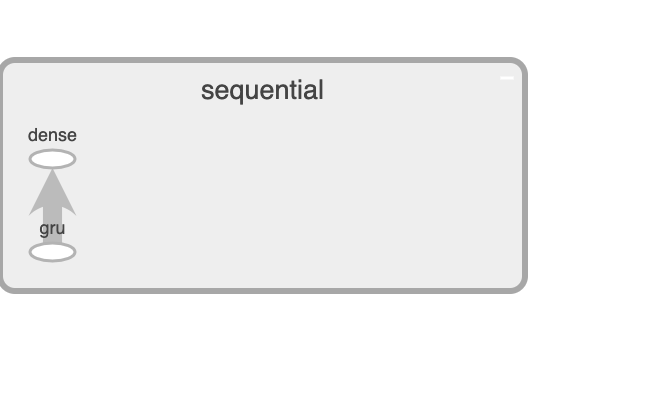

In [2]:
# load tensorboard conceptual graph
from IPython.display import Image
Image(filename='notebooks/assets/tb_conceptual_graph.png') 

I used `tf.keras.utils.plot_model()` api to obtain a more detailed description of each layer of the network and its number of units (e.g., I used 4 units for the GRU layer and 2 units for the classification layer.

Audio time series were reshaped to fit with the input format required by the GRU layer (number of samples in 1 batch, number of look back timesteps, 1 feature).

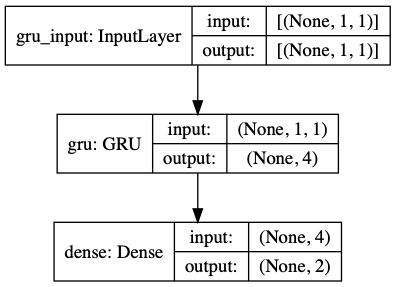

In [3]:
# load kedro inference pipeline
from IPython.display import Image
Image(filename='notebooks/assets/keras_model_architecture.png') 

The model had 94 parameters which were all trainable (see below plotted with `model.summary()`).

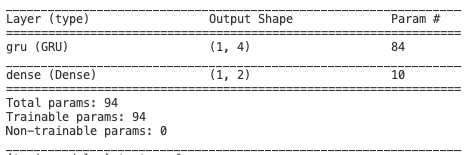

In [4]:
# load kedro inference pipeline
from IPython.display import Image
Image(filename='notebooks/assets/summary_params.png') 

## Experiments

I run several experiments changing the configurations of env/train_exps and env/predict_and_eval_exps pipelines.

```bash
kedro run --pipeline train --env train_exps
kedro run --pipeline predict_and_eval --env predict_and_eval_exps

```

### Approach

I chose a simple model as its simplicity permits to quickly iterate during development add new features and to debug easily. I tested several hypothesis to converge to a pipeline:

**Does a minimal model perform better than chance ?**

I first assumed that a small 2.8 sec chunk of audio (20% of a 14 sec file) would be sufficiently representative of the entire dataset and extracted the first 2.8 sec of 19-198-0003.wav file. This assumption is useful as it allows for quick training (4 min instead of 1 hour for a full audio) although at the expense of generalization. 

&nbsp; &nbsp; I trained a simple 1-layer GRU model which takes as input a single batch with one look-back timestep and projects to a fully connected binary classification layer with a softmax activation function. I first trained the model with 14 epochs. I used `Adam`, an adaptive optimizer that is well known to handle the complex training dynamics of recurrent networks better than simple gradient descent optimization. Training the model on a 2.8 secs audio from one speaker (20% of the full audio chunk) took 50 secs.

&nbsp; &nbsp; FRR on the full audio of another test subject (103-1240-0001) was 28% and precision 95% indicating that there is sufficient information in the data for a simple model to perform very well (**Experiment 1** in table). All FRRs reported during the experimental phase were done on the same test subject.

**Lower resolution, better speed?**: 

I tested two bits resolutions: float16 and float32 on one subject audio file (103-1240-0001, **experiment 1 vs. 2**). Both trained as fast and FRR and precision on test did not differ. I did not test for other subjects due to time constraints.

**Does learning from more look back timesteps improve model performance ?**

I tested 1 and 10 timesteps (0.06 ms and 1.2 ms respectively with the actual 16 KHz sampling rate) in **experiment 1 vs 3**.
- 10 timesteps took 5 min to train (compared to 50 sec for 1 timestep) but improved FRR 1.7 fold (from 28% to 16%), while keeping precision at 92% (from 95%).
- I judged performance good enough to continue with quick iterations and did not train with larger timesteps.

**Does a train/test split scheme in favor to the training set improve performance ?**

I splitted the 2.8 sec audio into a 50/50 training/test set size and compared it with a 70/30 scheme. Increasing training set from 50% to 70% slightly but likely not significantly worsened FRR from 28% to 31% on another test subject (103-1240-0001, **experiment 1 vs 4**).

**How long to convergence ?**:  

Training loss fell sharply and flattened at around 2 epochs which indicates that the model converges quickly. The validation loss indicates that loss tends to slowly increase over time, suggesting slight overfitting as training goes on.

**The more data the better ?**: 

I trained the model on 2.8 secs and 14 secs of the same training audio file, for 14 epochs:

Training the model on the full 14 sec audio file improved FRRs by 18% (from 28% to 23%, tested on speaker 103-1240, audio 103-1240-0001) but took 1 hour to train, while the 2.8 sec audio took 40 secs (**experiment 1 vs. 5**).

Precision slightly worsened from 95% to 93% indicating a slight increase in incorrect detections.

**Which activation sigmoid (default) vs. biased Softmax ?** 

I used a biased softmax activation at the Dense classification layer to compensate class imbalance and compared the results with the default sigmoid activation function.

False rejection rate slightly increased with a biased softmax (from 28% to 31% on other subjects test audios, **experiment 1 vs. 5**) while precision increased from 95% to 96%.

I used mlflow to track training duration. Training was much faster and took 6.9 sec rather than 9.8 sec until stop while epoch to convergence did not differ (2 to 3 epochs).

**Is Inference fast enough ?** 

Inference took 12.6 sec on a 15 sec audio that is 840 ms / sec.


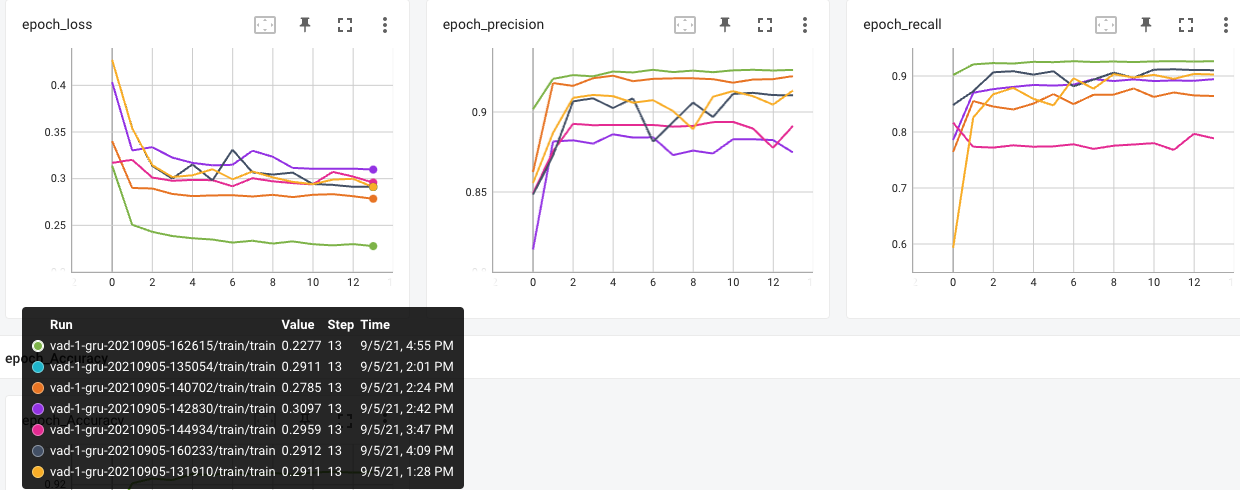

In [47]:
# load experiments
from IPython.display import Image
Image(filename='notebooks/assets/experiments_train_loss.png') 

The losses on the validation set (validation losses) are either quickly falling at the start either generally stable showing no sign of overfitting (increase in loss as training goes on).

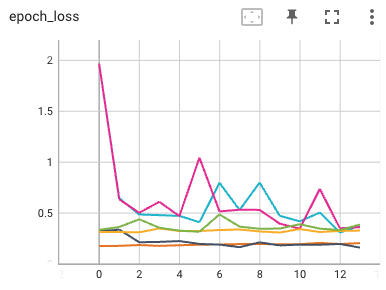

In [49]:
# load experiments
from IPython.display import Image
Image(filename='notebooks/assets/experiment_validation_loss.png') 

### A few sanity checks

I tested the inference pipeline:

1. Audio label mapping was shuffled
    - result: FRR worsened to 40% (possibly not significantly different from chance).

2. I tested a dummy model that always predicts "speech":
    - result: FRR worsened to 40% (precision was high which is expected if labels are imbalanced toward speech)

3. I tested a dummy model that always predicts "no speech":
    - result: FRR worsened to 100%, together with precision.
    
I tested the train pipeline by shuffling the audio label-mapping:

  - As expected:        
    - FRR was 100% and precision 0%
    - there was virtually no reduction in loss over epochs indicating no learning

### Final setup

**Training dataset**:

- 2.8 secs audio from one speaker: this small chunk took 4 min to train while using a full 14 secs audio file (i.e., 5 times more data) took 1 hour for just 18% improvement in FRR.
All remaining training in the report rely on the 2.8 sec audio chunk from 19-198 speaker.
- 16 bits resolution

**Basic model's architecture**:

- 1-layer GRU with 4 units 
- Dense classification layer with 2 units, a Softmax activation with an initial bias that counterbalances the label imbalance

**Training**:

- **batch size**: 1 batch 
- **look back timesteps**: 10 timesteps    
- **epochs**: 14 epochs 
- **train/test split**: the 2.8 sec dataset was splitted on a 70% train and 30 % test dataset for a quick visual check of prediction performance generalisation on a small test set (see tensorboard test metrics. Here I rather report the model metrics calculated on the other subjects' entire dataset, which tells more on model generalisation performances.
- **Cross-validation**: the splitted training dataset was further split into 60% train and 40 % validation to display validation performance and loss curve in tensorboard  

## Results

### Description of the audio data

#### There are several speakers

Listening to a sample of the audio files revealed that a variety of speakers

- Humans
    - men: e.g., 118-47824-0000
    - women: e.g., 118-47824-0000
- Synthetic:
    - men: e.g., 1263-141777-0000

I also characterised speeches by their variety of amplitudes and pace:

- Normal vs fast pace: e.g., 1578-6379-0017  
- Loud vs, low volume: e.g., 1447-130551-0019

We show below the best typical example of an audio signal (top panel). and its associated speech labels "1" for speech and "0" for no speech (bottom panel).

All audio signals were 32 bits float single channel time series. We run a few sanity checks:

In [50]:
# load all data
data_path = "data/01_raw/vad_data/"
audio_files = glob.glob(f"{data_path}*.wav")
audio_files.sort()
label_files = glob.glob(f"{data_path}*.json")
label_files.sort()

# run sanity test on file-label name mapping and sorting
correct_mapping = []
for aud, lbl  in zip(audio_files, label_files):
    correct_mapping.append(os.path.splitext(aud)[0] == os.path.splitext(lbl)[0])
print(f"- the {sum(correct_mapping)} label files were correctly mapped with the {len(audio_files)} audio files")

- the 957 label files were correctly mapped with the 957 audio files


- Number: 34 speakers
- Speakers'ID: ['103' '1034' '1040' '1069' '1081' '1088' '1098' '1116' '118' '1183'
 '1235' '1246' '125' '1263' '1334' '1355' '1363' '1447' '1455' '150'
 '1502' '1553' '1578' '1594' '1624' '163' '1723' '1737' '1743' '1841'
 '1867' '1898' '19' '1926']


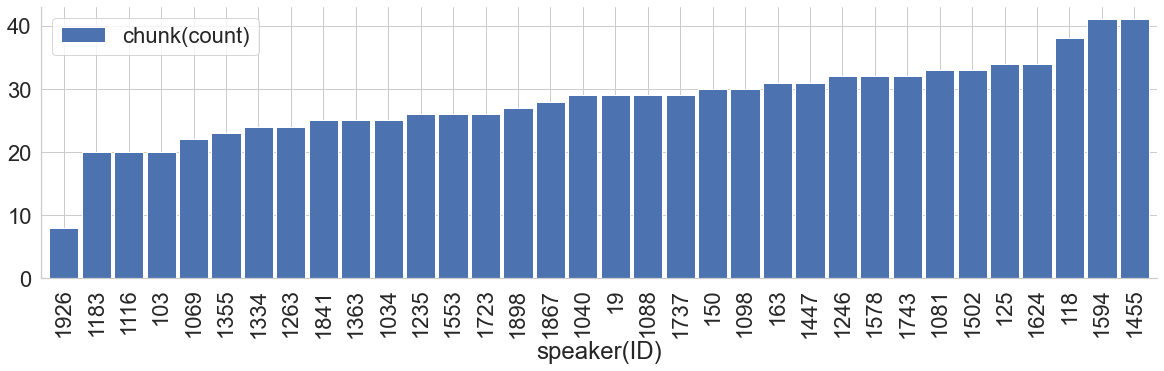

In [51]:
# get speaker info
file_speaker = [os.path.basename(file).split("-")[0] for file in audio_files]
speaker_set = np.unique(file_speaker)
print("- Number:", len(speaker_set), "speakers")
print("- Speakers'ID:", speaker_set)

# get number of chunks per speaker
speaker, nb_chunks = zip(*Counter(file_speaker).items())
counts = pd.DataFrame(data=(speaker, nb_chunks), index=["speaker(ID)", "chunk(count)"]).T
counts.sort_values(by="chunk(count)").plot.bar(x="speaker(ID)", figsize=(20, 5), width=0.9);
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

In [53]:
# define a few useful functions
def read_X(audio_path):
    sample_rate, data = scipy.io.wavfile.read(
        audio_path
    )
    sample_size = len(data)
    time_unit = 1 / sample_rate
    duration_in_sec = time_unit * len(data)
    timestamp = np.arange(0, len(data), 1) * time_unit
    return {
        "audio": {
            "data": data.reshape(sample_size, 1),
            "metadata": {
                "sample_rate": sample_rate,
                "sample_size": sample_size,
                "time_unit": time_unit,
                "duration_in_sec": duration_in_sec,
                "timestamp": timestamp,
            },
        }
    }
    
def load_Y(label_path):
    return pd.read_json(label_path)    

def sync_audio_and_labels(audio, label):

    # get data
    data = audio["audio"]["data"]
    time_unit = audio["audio"]["metadata"]["time_unit"]
    sample_size = audio["audio"]["metadata"]["sample_size"]

    # create timestamps
    audio["audio"]["metadata"]["timestamp"] = np.arange(0, len(data), 1) * time_unit

    # case label exists
    # synchronize labels with audio
    synced_label = np.zeros((sample_size, 1))
    array = label.values
    for ix in range(array.shape[0]):
        interval = array[ix][0]
        speech_start = interval["start_time"]
        speech_end = interval["end_time"]
        span = np.where(
            np.logical_and(
                audio["audio"]["metadata"]["timestamp"] >= speech_start,
                audio["audio"]["metadata"]["timestamp"] <= speech_end,
            )
        )
        synced_label[span] = 1
    audio["label"] = synced_label
    return audio

def load_synced_audio_and_label(audio_path, label_path):
    audio = read_X(audio_path)
    label = load_Y(label_path)
    return sync_audio_and_labels(audio, label)
    
def plot_labelled_audio(timestamp, audio, labels, n_sample):
    # plot audio
    f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(20,5))
    ax1.plot(timestamp, audio[:n_sample], "r-")

    # plot label
    ax2.plot(timestamp, labels[:n_sample], "b-")
    ax2.set_ylim([-0.1, 1.1])
    plt.show()
    ax1.tick_params(labelsize=8)

    return f, ax1, ax2

We show below a few interesting example chunks for two speakers.
- Audio seem well labelled (see supplementary).
- Background noise is low and stationary.


SPEAKER 19
  data/01_raw/vad_data/19-198-0003.wav
  data/01_raw/vad_data/19-198-0003.json


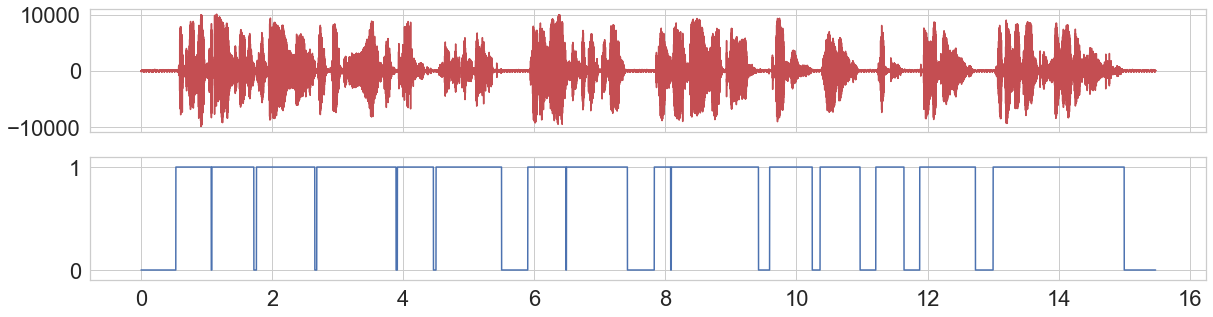

SPEAKER 103
  data/01_raw/vad_data/103-1241-0027.wav
  data/01_raw/vad_data/103-1241-0027.json


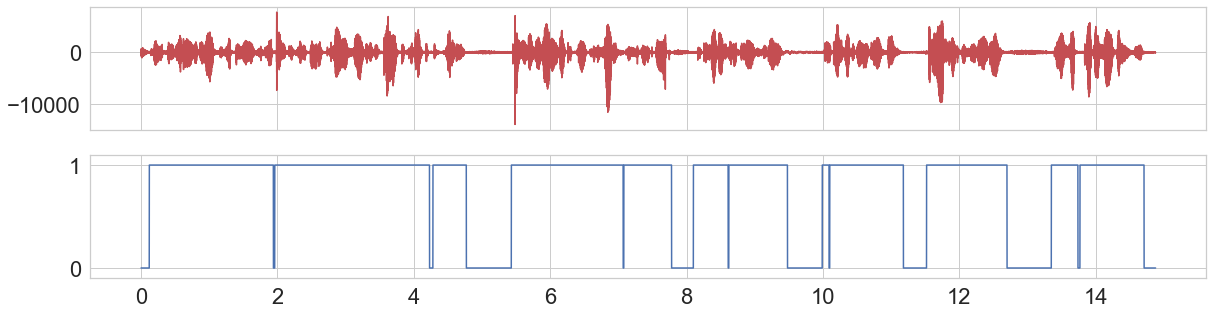

In [54]:
# show an example per speaker
exple_pos = [920, 17]

# sync audio and labels
for ix, exple in enumerate(exple_pos):
    print(f"SPEAKER {file_speaker[exple]}")
    print(" " , audio_files[exple])
    print(" " , label_files[exple])    
    audio = load_synced_audio_and_label(audio_files[exple], label_files[exple])
    f, ax1, ax2 = plot_labelled_audio(
        audio["audio"]["metadata"]["timestamp"], 
        audio["audio"]["data"], 
        audio["label"], 
        n_sample=len(audio["label"]), 
    )

We validated that all audio files were associated with a .json label file.


In [55]:
# data quality check
print("- audio file sample size:", len(audio_files))
print("- label file sample size:", len(label_files))

- audio file sample size: 957
- label file sample size: 957


The entire sample could be loaded quickly:

In [56]:
# loading
tic = time.time()
audio_data = [scipy.io.wavfile.read(audio) for audio in audio_files]
print("- loading duration:", np.round(time.time()-tic,2), "sec")

- loading duration: 3.24 sec


Sample size and sampling rate:

In [57]:
# get sample rate per audio
sample_rates = [audio for audio in np.array(audio_data)[:,0]]
sample_rate = np.unique(sample_rates)
print("Sample rate information:")
print("-", len(sample_rate), "sample rate(s)")
print("- rate:", np.unique(sample_rates)[0], "Hz")

Sample rate information:
- 1 sample rate(s)
- rate: 16000 Hz


We kept the signal at 16Khz which is enough to cover the frequency range of human speech according to the literature (Human voice b/w `85hz to 8khz` [REF], hearing b/w `20 hz to 20kh`[REF]).

In [58]:
# get sample size per audio
sample_sizes = [len(audio) for audio in np.array(audio_data)[:,1]]
print("Sample size information:")
print("-", len(np.unique(sample_sizes)), "sample size(s)")
print("- max:", max(sample_sizes), "samples (", max(sample_sizes)/sample_rate, "secs)")
print("- min:", min(sample_sizes), "samples (", min(sample_sizes)/sample_rate, "secs)")
print("- median:", np.median(sample_sizes), "samples (", np.median(sample_sizes)/sample_rate, "secs)")

Sample size information:
- 711 sample size(s)
- max: 275280 samples ( [17.205] secs)
- min: 22560 samples ( [1.41] secs)
- median: 222080.0 samples ( [13.88] secs)


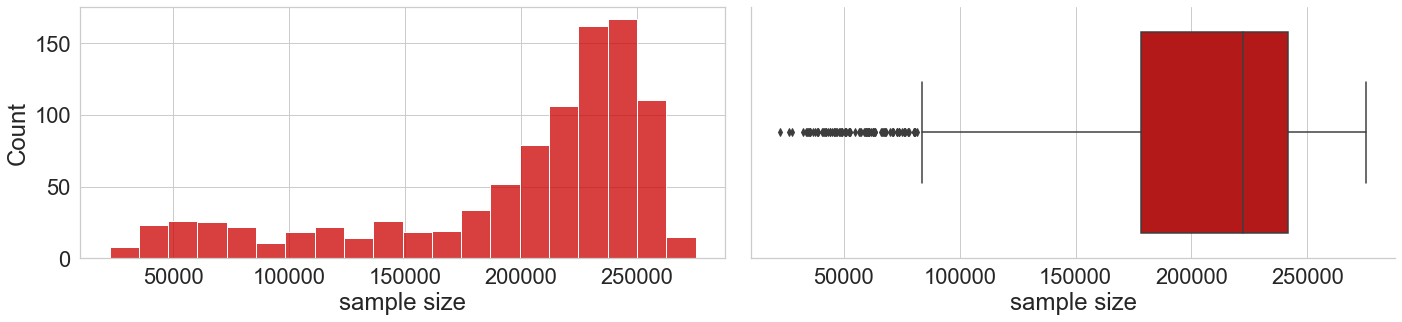

In [59]:
# psample size distribution
# plot SNR
df_size = pd.DataFrame(sample_sizes, columns=["sample size"])
f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
# histogram
sns.histplot(ax=ax1, data=df_size, x="sample size", color=[.8,0,0])
# box plot
sns.boxplot(ax=ax2, x=df_size["sample size"], color=[.8,0,0])
plt.tight_layout()
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

**Signal amplitudes**: the true decibel amplitude of the audio will depend on each speaker's microphone characteristics, the speaker's distance to its microphone, the speaker's volume configuration. Having no acces to these information we did not derive the true decibel amplitude (dB) from the raw audio signal amplitude or compared absolute amplitudes between speakers. Rather we compared the signals' signal-to-noise ratio (SNR).

### Speech signals are nearly pure

I made the naive assumption that audio can be linearly decomposed as the sum of independent speech and noise amplitude components. This assumption would not hold in case of reverberation.

$$audio = speech + noise $$

Where i respectively categorize noise as the portion of the audio that is not labelled as speech. Thus:

$$speech = audio - noise$$

The signal to noise ratio in decibel is given by: 

$$SNR = 20.log_{10}(\frac{speech\_rms}{noise\_rms})$$

where speech\_rms and noise\_rms are the root mean square of the speech_signal and of the noise



In [60]:
# define some useful functions
def get_noise_rms(audio_path, label_path):
    synced = load_synced_audio_and_label(audio_path, label_path)
    audio = synced["audio"]["data"]
    audio = audio.astype("float32")
    label = synced["label"]    
    noise = audio[label==0]
    return np.sqrt(np.mean(noise**2))

def denoise_speech(audio_path, label_path):
    synced = load_synced_audio_and_label(audio_path, label_path)
    audio = synced["audio"]["data"]
    audio = audio.astype("float32")    
    label = synced["label"]    
    noise = audio[label==0]
    # dampen signals below max noise amplitude to 0
    speech = audio.copy()
    max_noise = max(noise)
    min_noise = min(noise)
    speech[np.logical_and(speech<=max(noise), speech>=min(noise))] = 0    
    return audio, speech 

def get_speech_rms(audio_path, label_path):
    audio, speech = denoise_speech(audio_path, label_path)
    return np.sqrt(np.mean(speech**2))

def plot_denoised_speech(audio, denoised_speech):
    # plot audio
    f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(20,6));
    ax1.plot(audio, "r-");
    ax1.set_title("Raw audio");

    # plot denoised speech
    ax2.plot(denoised_speech, "b-");
    ax2.set_title("Denoised audio");    
    ax1.tick_params(labelsize=8);
    ax2.set_xlabel("timestamp (sample)");
    plt.tight_layout();
    plt.show();

def get_snr(n_rms, s_rms):
    return 20*np.log10(s_rms / n_rms)

In [61]:
# get SNR of each audio file
snrs = []
for ix in range(len(audio_files)):
    n_rms = get_noise_rms(audio_files[ix], label_files[ix])
    s_rms = get_speech_rms(audio_files[ix], label_files[ix])
    snr = get_snr(n_rms, s_rms)
    snrs.append(snr)

SNR was spread over negative and positive values (-30 dB to +40 dB). The occurrence of negative SNR indicates that some recordings have noise with larger amplitudes the speech signal.

SNR was on average 15 dB with clear outliers towards the left tail (negative values, below the left interquartile range).

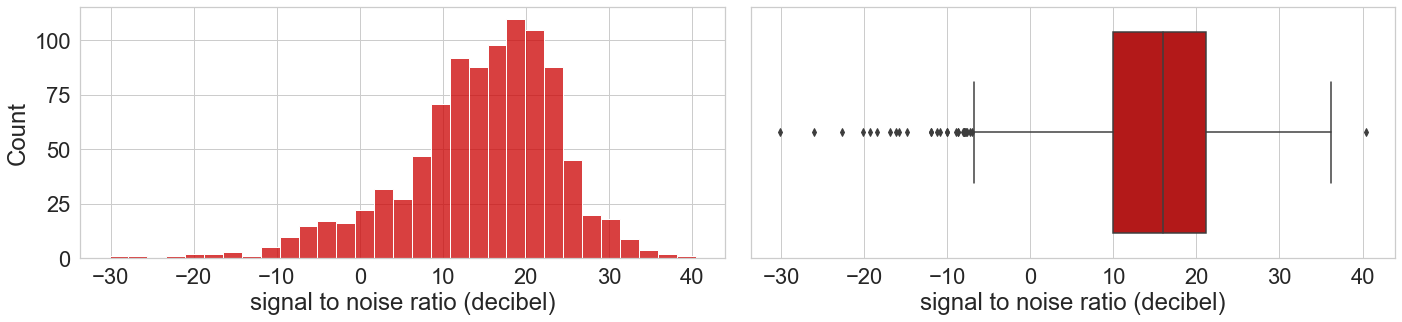

In [16]:
# format SNR for plot
df_snr = pd.DataFrame(snrs, columns=["signal to noise ratio (decibel)"])
df_snr = df_snr.replace([-np.inf], np.nan)

# plot histogram
f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
sns.histplot(ax=ax1, data=df_snr, x="signal to noise ratio (decibel)", color=[.8,0,0])

# box statistical description with box plot
sns.boxplot(ax=ax2, x=df_snr["signal to noise ratio (decibel)"], color=[.8,0,0])
plt.tight_layout()

I show below what noise dampening (blue in bottom panel) does to the raw signal below (red, in top panel)
for an example audio file.

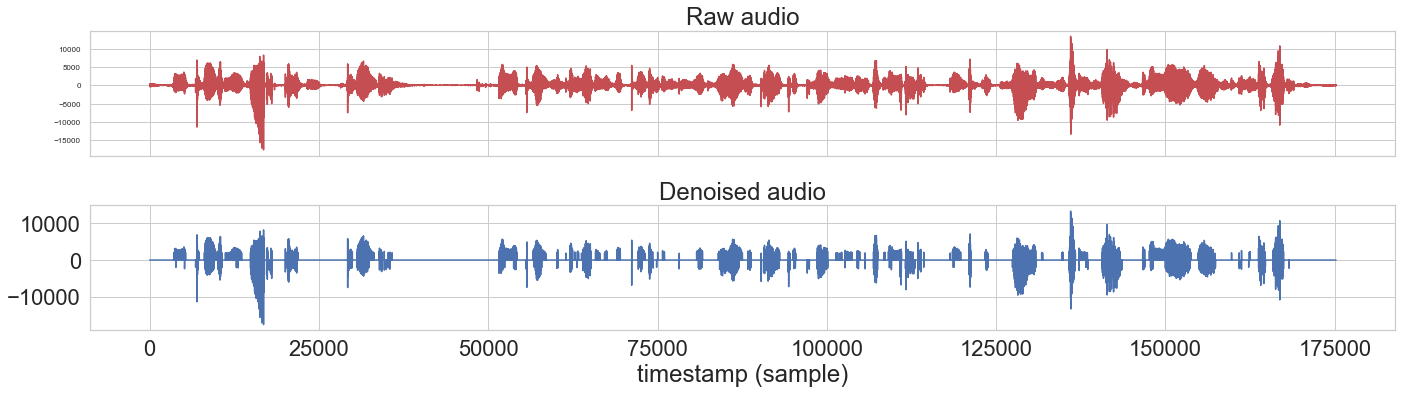

In [17]:
audio, denoised_speech = denoise_speech(audio_files[ix], label_files[ix])
plot_denoised_speech(audio, denoised_speech)

### Speech and no-speech classes are imbalanced in the training dataset

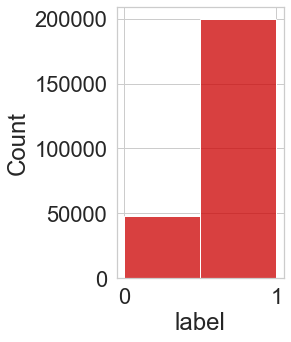

In [62]:
# load synced data
train_audio_path = "data/01_raw/vad_data/19-198-0003.wav"
train_label_path = "data/01_raw/vad_data/19-198-0003.json"
data = load_synced_audio_and_label(train_audio_path, train_label_path)

# plot SNR
f, ax1 = plt.subplots(1,1, figsize=(3,5))
df_data = pd.DataFrame(data["label"], columns=["label"])
sns.histplot(ax=ax1, data=df_data, x="label", color=[.8,0,0], bins=2);

### The 1-layer GRU net converges within 7 epochs

I monitored training quality in Tensorboard api. I display below the training loss (green curve, left panel) calculated for 14 training epochs (x-axes ranging from 0 to 14) and validation loss (orange curve, left panel). I used the model referred to in the `final setup` section with 10 timesteps look-back (see logged runs in tensorboard for vad-1-gru-20210905-162615/train/train, vad-1-gru-20210905-162615/train/validation in tensorboard web api). The categorical cross-entropy training loss quickly fell sharply and flattened at about 2 epochs. A closer look at validation loss reveals a slight increase that indicate overfitting as training goes on after 3 epochs.

I also monitored recall to evaluate improvement in FRR. Recall quickly increased (thus FRR decreased) by 2% up to epoch 2 and took about 4 epochs to stabilise on the training set. Recall remained stable on the validation set.

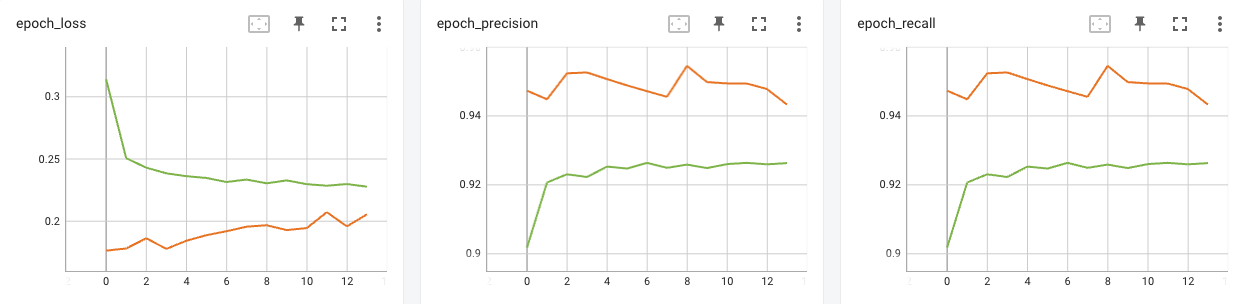

In [64]:
# load kedro inference pipeline
from IPython.display import Image
Image(filename='notebooks/assets/loss_recall_per_epoch.png') 

### Weights and biases follow well-behaved multimodal distributions 

Both the Gru and dense layer weight distributions did not stay stuck at their initial values  (no vanishing gradient problem), nor show extreme outliers. The weight and bias slowly but gradually converged toward new values. 

**Gru layer**

The GRU layer has 3 types of trainable parameters:
- weights ("kernel_0")
- recurrent weights ("kernel_0")
- biases ("kernel_0")

I will refer to iterations as epochs as for a single batch iterations equal the number of epochs.

- GRU'S weight and bias values: 
    - The weight distribution was very sparse with central peak at 0 and a few weights spreading further from 0 toward negative and positive values as training progresses.
    - GRU biases and recurrent weights also spread out gradually toward larger range of negative and positive values as training progresses.
- Dense's weight and bias values:
    - Weights distrbution do not visibly change while bias concentrate toward a single value as learning progresses. 

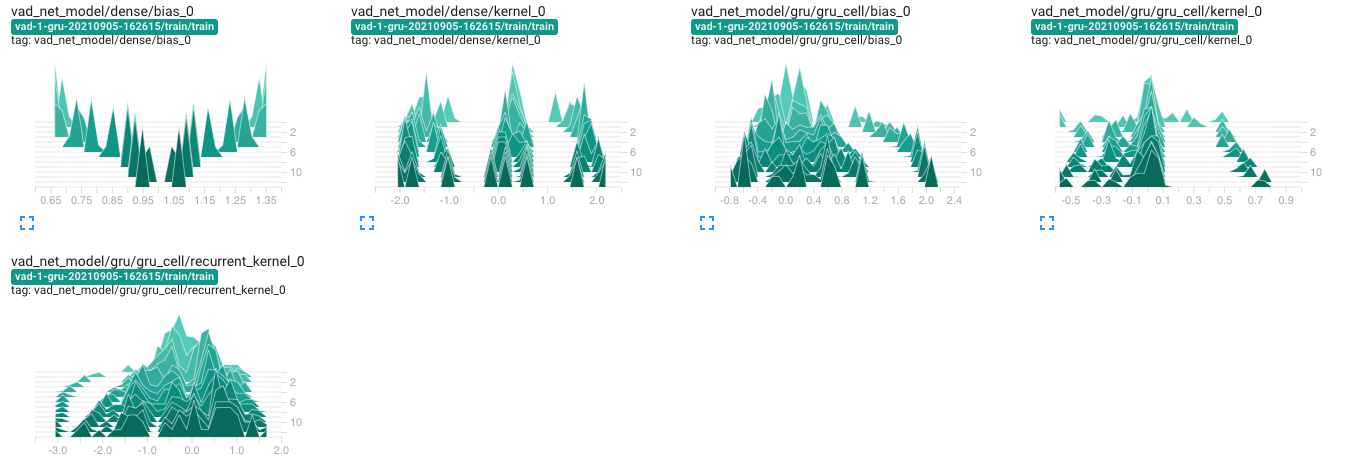

In [65]:
# load kedro inference pipeline
from IPython.display import Image
Image(filename='notebooks/assets/biases_and_weights.png') 

These changes in the bias and weights distributions are more apparent on the distribution plots of weight and bias vs. epochs (different shading columns represent the distributions' 90th, 60th percentiles ...).

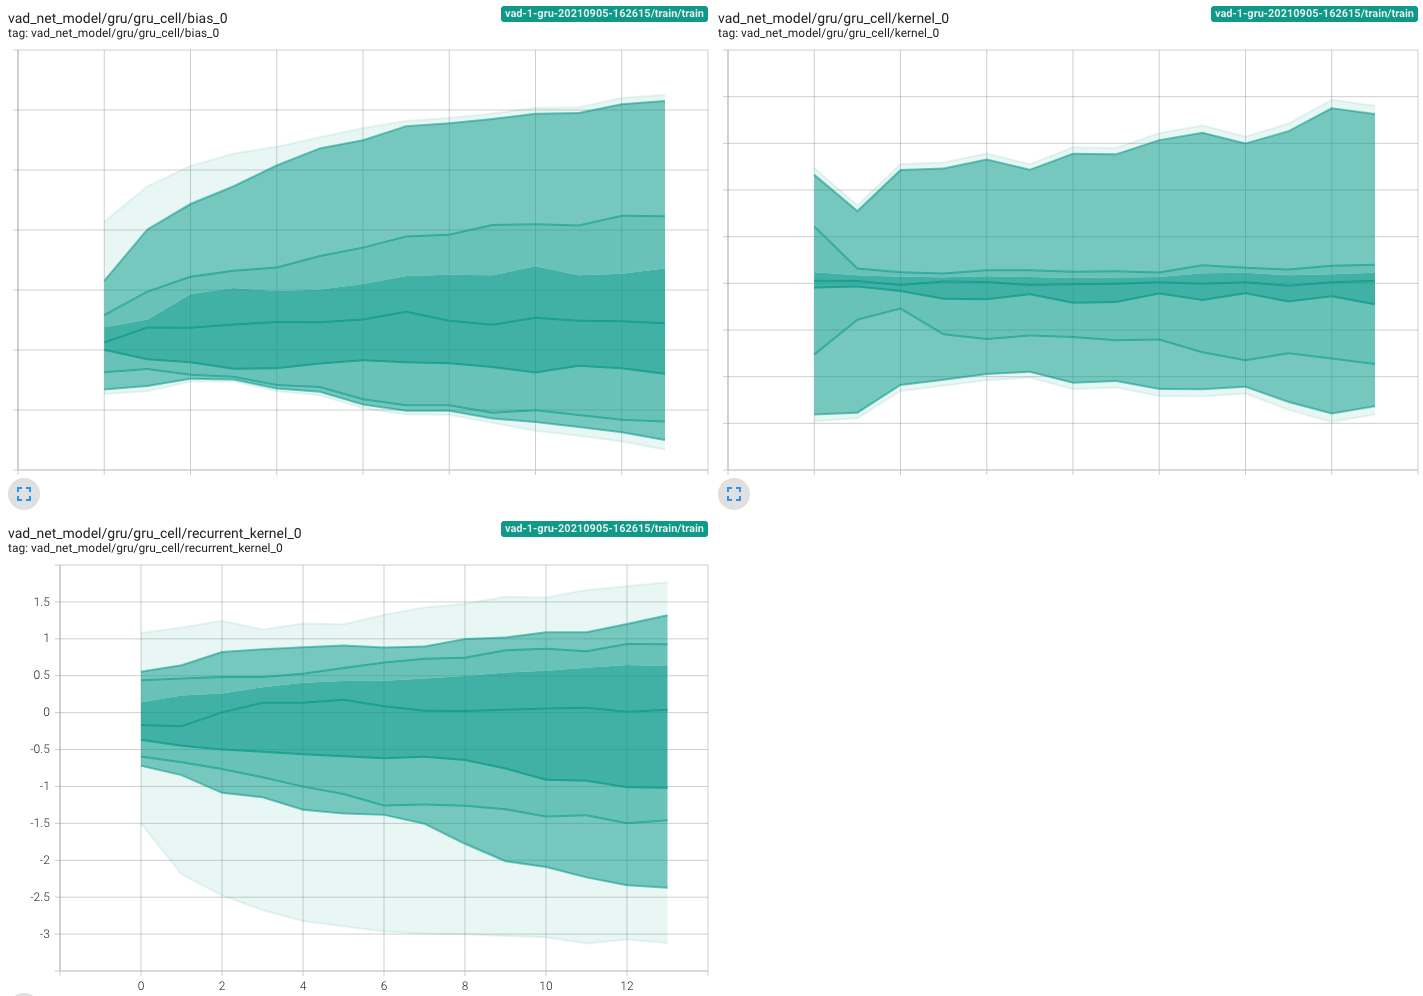

In [66]:
# load kedro inference pipeline
from IPython.display import Image
Image(filename='notebooks/assets/tb_gru_weights_hist_per_epoch.png') 

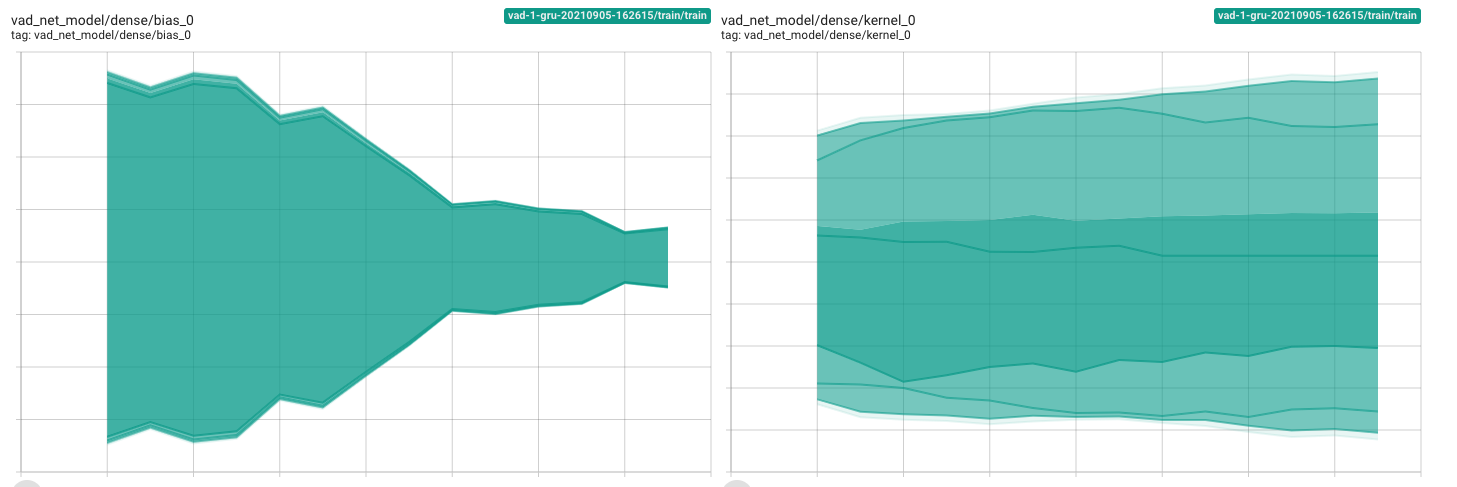

In [67]:
# load kedro inference pipeline
from IPython.display import Image
Image(filename='notebooks/assets/tb_dense_weights_hist_per_epoch.png') 

### A 1-layer GRU model predicts well

I tested the model on an audio file of each of the 34 speakers' (about 3.5 min, for 15 sec inference per audio file). I chose their first audio for simplicity. Further analyses must assess whether the first audio is representative of speakers remaining recordings. I chose a sample and not the entire dataset because inference would take more than 3 hours on the 957 files. I show below the distribution of False rejection rates. 

In [69]:
# define data engineering pipeline
from kedro.pipeline import Pipeline, node
from vad.pipelines.data_eng.nodes import Etl, DataEng

def run_data_eng(**kwargs):
    """Data engineering pipeline
    """
    return Pipeline(
        [
            node(
                func=Etl.test_on_label,
                inputs=["synced", "params:TEST"],
                outputs="tested",
                name="test_label",
            ),
            node(
                func=DataEng.set_resolution,
                inputs=["tested", "params:DATA_ENG"],
                outputs="floated32",
                name="float_and_32bit",
            ),
            node(
                func=DataEng.reshape_input_for_net,
                inputs=["floated32", "params:DATA_ENG"],
                outputs="prod_audio",
                name="reshape_for_net",
            ),
        ]
    )

In [ ]:
# run inference pipeline
runner = SequentialRunner()
FRRs = []
precisions = []
f1s = []
accuracys = []
predictions = []

_, exple_pos = np.unique(file_speaker, return_index=True, axis=0)

# set inference pipeline parameters
DATA_ENG = MemoryDataSet(data={
             "LABEL": True,
             "REDUCE_TRAIN": False,
             "TIMESTEPS": 10,
             "N_CLASSES": 2,
             "RESOLUTION": "float16",
         })
TEST = MemoryDataSet(data={
      "SHUFFLE_LABEL": False, # must be false: random audio-label mapping
      "ALL_SPEECH": False, # must be false: random audio-label mapping
      "NO_SPEECH": False, # must be false: random audio-label mapping  
     })
TRAIN = MemoryDataSet(data={
  "NAME": "BASIC",      
  "LOSS": "CategoricalCrossentropy"
})

# load trained model
model = TensorFlowModelDataset(filepath="data/06_models/model")

# build pipeline
pipeline = Pipeline(
    [
        data_eng.run_for_inference(), 
        inference.run(), 
        evaluate.run()
    ]
)

for exple in exple_pos:
    tic = time.time()
    
    # track experiments
    mlflow.set_experiment("/explore")
    mlflow.end_run()
    with mlflow.start_run():

        # load and sync data to predict
        synced = load_synced_audio_and_label(audio_files[exple], label_files[exple])
        synced = MemoryDataSet(data=synced)

        # config. pipeline datasets and parameters inputs
        io = DataCatalog(data_sets={
                                    'params:DATA_ENG': DATA_ENG,
                                    'params:TEST': TEST, 
                                    'params:TRAIN': TRAIN,
                                    "model": model,
                                    "synced": synced
                                   }
                        )

        # compute prediction        
        prediction = runner.run(pipeline.to_nodes("predict-production-audio"), catalog=io)
        
        # compute metrics
        metrics = runner.run_only_missing(pipeline, io)

        # record
#         labels.append(label)        
        predictions.append(predictions)
        FRRs.append(metrics["metrics"]["false_rejection_rate"].item())
        precisions.append(metrics["metrics"]["precision"].item())
        f1s.append(metrics["metrics"]["f1"].item())
        accuracys.append(metrics["metrics"]["accuracy"].item())
print(np.round(time.time()-tic,2), "secs")

INFO: '/explore' does not exist. Creating a new experiment
2021-09-05 18:04:06,277 - kedro.io.data_catalog - INFO - Loading data from `params:DATA_ENG` (MemoryDataSet)...
2021-09-05 18:04:06,295 - kedro.pipeline.node - INFO - Running node: load_label: load_Y([params:DATA_ENG]) -> [label]
2021-09-05 18:04:06,305 - kedro.io.data_catalog - INFO - Saving data to `label` (MemoryDataSet)...
2021-09-05 18:04:06,307 - kedro.runner.sequential_runner - INFO - Completed 1 out of 7 tasks
2021-09-05 18:04:06,310 - kedro.pipeline.node - INFO - Running node: read_audio: read_X(None) -> [audio]
2021-09-05 18:04:06,319 - kedro.io.data_catalog - INFO - Saving data to `audio` (MemoryDataSet)...
2021-09-05 18:04:06,321 - kedro.runner.sequential_runner - INFO - Completed 2 out of 7 tasks
2021-09-05 18:04:06,322 - kedro.io.data_catalog - INFO - Loading data from `audio` (MemoryDataSet)...
2021-09-05 18:04:06,324 - kedro.io.data_catalog - INFO - Loading data from `label` (MemoryDataSet)...
2021-09-05 18:04:0

2021-09-05 18:04:34,391 - kedro.runner.sequential_runner - INFO - Completed 9 out of 11 tasks
2021-09-05 18:04:34,392 - kedro.io.data_catalog - INFO - Loading data from `prediction_for_eval` (MemoryDataSet)...
2021-09-05 18:04:34,393 - kedro.io.data_catalog - INFO - Loading data from `label_for_eval` (MemoryDataSet)...
2021-09-05 18:04:34,394 - kedro.pipeline.node - INFO - Running node: evaluate-predictions: evaluate([label_for_eval,prediction_for_eval]) -> [metrics]
2021-09-05 18:04:34,725 - kedro.io.data_catalog - INFO - Saving data to `metrics` (MemoryDataSet)...
2021-09-05 18:04:34,727 - kedro.runner.sequential_runner - INFO - Completed 10 out of 11 tasks
2021-09-05 18:04:34,728 - kedro.io.data_catalog - INFO - Loading data from `prediction_for_eval` (MemoryDataSet)...
2021-09-05 18:04:34,730 - kedro.io.data_catalog - INFO - Loading data from `label_for_eval` (MemoryDataSet)...
2021-09-05 18:04:34,732 - kedro.pipeline.node - INFO - Running node: get-confusion: get_confusion([label_

2021-09-05 18:04:53,336 - kedro.io.data_catalog - INFO - Saving data to `prod_audio` (MemoryDataSet)...
2021-09-05 18:04:53,351 - kedro.runner.sequential_runner - INFO - Completed 6 out of 11 tasks
2021-09-05 18:04:53,353 - kedro.io.data_catalog - INFO - Loading data from `model` (TensorFlowModelDataset)...
2021-09-05 18:05:04,878 - kedro.io.data_catalog - INFO - Loading data from `prod_audio` (MemoryDataSet)...
2021-09-05 18:05:04,923 - kedro.pipeline.node - INFO - Running node: predict-production-audio: predict([model,prod_audio]) -> [prediction]
2021-09-05 18:05:17,307 - kedro.io.data_catalog - INFO - Saving data to `prediction` (MemoryDataSet)...
2021-09-05 18:05:17,310 - kedro.runner.sequential_runner - INFO - Completed 7 out of 11 tasks
2021-09-05 18:05:17,312 - kedro.io.data_catalog - INFO - Loading data from `prod_audio` (MemoryDataSet)...
2021-09-05 18:05:17,324 - kedro.pipeline.node - INFO - Running node: reshape-label: reshape_label([prod_audio]) -> [label_for_eval]
2021-09-

2021-09-05 18:05:40,056 - kedro.io.data_catalog - INFO - Loading data from `params:TEST` (MemoryDataSet)...
2021-09-05 18:05:40,064 - kedro.pipeline.node - INFO - Running node: test_label: test_on_label([params:TEST,synced]) -> [tested]
2021-09-05 18:05:40,065 - kedro.io.data_catalog - INFO - Saving data to `tested` (MemoryDataSet)...
2021-09-05 18:05:40,068 - kedro.runner.sequential_runner - INFO - Completed 4 out of 11 tasks
2021-09-05 18:05:40,071 - kedro.io.data_catalog - INFO - Loading data from `tested` (MemoryDataSet)...
2021-09-05 18:05:40,074 - kedro.io.data_catalog - INFO - Loading data from `params:DATA_ENG` (MemoryDataSet)...
2021-09-05 18:05:40,084 - kedro.pipeline.node - INFO - Running node: float_and_32bit: set_resolution([params:DATA_ENG,tested]) -> [floated32]
2021-09-05 18:05:40,089 - kedro.io.data_catalog - INFO - Saving data to `floated32` (MemoryDataSet)...
2021-09-05 18:05:40,093 - kedro.runner.sequential_runner - INFO - Completed 5 out of 11 tasks
2021-09-05 18:0

2021-09-05 18:06:23,567 - kedro.io.data_catalog - INFO - Loading data from `prediction` (MemoryDataSet)...
2021-09-05 18:06:23,581 - kedro.io.data_catalog - INFO - Loading data from `params:DATA_ENG` (MemoryDataSet)...
2021-09-05 18:06:23,589 - kedro.pipeline.node - INFO - Running node: load_label: load_Y([params:DATA_ENG]) -> [label]
2021-09-05 18:06:23,598 - kedro.io.data_catalog - INFO - Saving data to `label` (MemoryDataSet)...
2021-09-05 18:06:23,600 - kedro.runner.sequential_runner - INFO - Completed 1 out of 11 tasks
2021-09-05 18:06:23,602 - kedro.pipeline.node - INFO - Running node: read_audio: read_X(None) -> [audio]
2021-09-05 18:06:23,611 - kedro.io.data_catalog - INFO - Saving data to `audio` (MemoryDataSet)...
2021-09-05 18:06:23,614 - kedro.runner.sequential_runner - INFO - Completed 2 out of 11 tasks
2021-09-05 18:06:23,616 - kedro.io.data_catalog - INFO - Loading data from `audio` (MemoryDataSet)...
2021-09-05 18:06:23,618 - kedro.io.data_catalog - INFO - Loading data 

2021-09-05 18:06:48,141 - kedro.io.data_catalog - INFO - Saving data to `floated32` (MemoryDataSet)...
2021-09-05 18:06:48,145 - kedro.runner.sequential_runner - INFO - Completed 5 out of 7 tasks
2021-09-05 18:06:48,146 - kedro.io.data_catalog - INFO - Loading data from `floated32` (MemoryDataSet)...
2021-09-05 18:06:48,149 - kedro.io.data_catalog - INFO - Loading data from `params:DATA_ENG` (MemoryDataSet)...
2021-09-05 18:06:48,151 - kedro.io.data_catalog - INFO - Loading data from `params:TRAIN` (MemoryDataSet)...
2021-09-05 18:06:48,168 - kedro.pipeline.node - INFO - Running node: reshape_for_net: reshape_input_for_net([floated32,params:DATA_ENG,params:TRAIN]) -> [prod_audio]
2021-09-05 18:06:49,022 - kedro.io.data_catalog - INFO - Saving data to `prod_audio` (MemoryDataSet)...
2021-09-05 18:06:49,034 - kedro.runner.sequential_runner - INFO - Completed 6 out of 7 tasks
2021-09-05 18:06:49,036 - kedro.io.data_catalog - INFO - Loading data from `model` (TensorFlowModelDataset)...
202

I show below the FRR statistics calculated over the FRR calculated from the first audio of the test subjects with various other usual performance metrics:

In [26]:
# describe metrics
df = pd.DataFrame(FRRs, columns=["FRR"]).describe()
df["precision"] = pd.DataFrame(precisions).describe()
df["f1"] = pd.DataFrame(f1s).describe()
df["accuracy"] = pd.DataFrame(accuracys).describe()
df

FRR     precision            f1      accuracy
count  3.400000e+01  3.400000e+01  3.400000e+01  3.400000e+01
mean   1.508353e-01  9.119925e-01  8.794579e-01  7.952717e-01
std    2.817298e-17  1.126919e-16  1.126919e-16  1.126919e-16
min    1.508353e-01  9.119925e-01  8.794579e-01  7.952717e-01
25%    1.508353e-01  9.119925e-01  8.794579e-01  7.952717e-01
50%    1.508353e-01  9.119925e-01  8.794579e-01  7.952717e-01
75%    1.508353e-01  9.119925e-01  8.794579e-01  7.952717e-01
max    1.508353e-01  9.119925e-01  8.794579e-01  7.952717e-01

The FRR histogram (shown below) concentrates near 9% with no apparent outlier. 
This indicates that the model generalize well to all speakers: human men, women and synthetic 
speakers. 

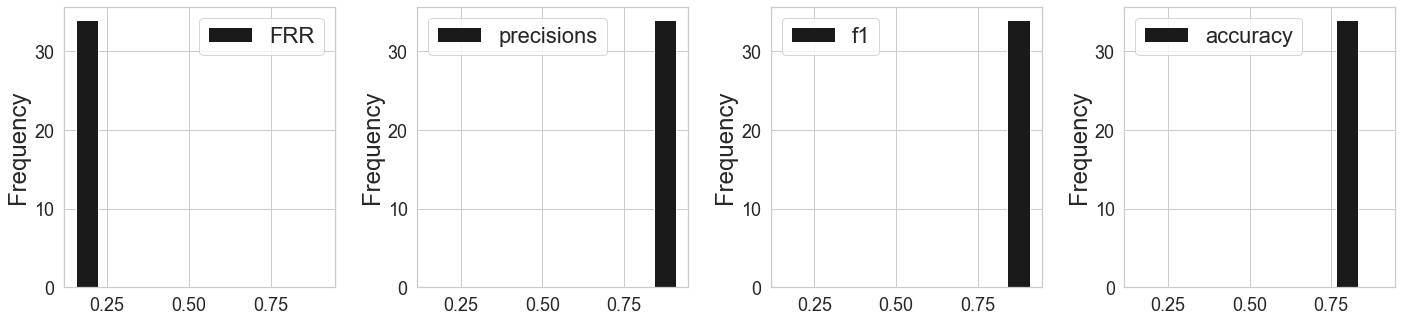

In [27]:
# plot metrics histogram over subjects
data = np.array([FRRs, precisions, f1s, accuracys]).T
df_per_speaker = pd.DataFrame(data=data , columns=["FRR", "precisions", "f1", "accuracy"])
df_per_speaker.plot.hist(
    subplots=True, 
    legend=True, 
    layout=(1, 4),
    figsize=(20,5), 
    rwidth=0.9, 
    color="k",
    fontsize=18);
plt.tight_layout()

### Adding VAD modification

#### Enforcing a minimum speech time

The minimum speech time observed in the dataset was very short. A realistic minimum speech duration would be 1 secs, to say "hi" for example.

In [28]:
# calculate minimum speech time over speakers
def get_min_speech_time(label_files):
    speech_times = []
    for file in label_files:
        label = pd.read_json(file)
        for interval in label.values:
            speech_time = interval[0]["end_time"] - interval[0]["start_time"]
            speech_times.append(speech_time)
    return min(speech_times)

In [29]:
min_speech_time = get_min_speech_time(label_files)
print("The minimum speech time derived from the data was:", np.round(1000*min_speech_time,1), "ms")

The minimum speech time derived from the data was: 10.0 ms


##### Method 1: Filtering out speech events with a duration below minimum speech time

To enforce a minimum speech time I modified the training labels before fitting the model. I chose a mimum speech time of 1,000 ms (16,000 points at 16Khz). I detected speech event intervals start and end timestamps and re-labelled as not speech ("0") all speech intervals  with durations below 1000 ms (length below 16,000 points).

Filtering out short speech events with duration below 1 sec should favor model weights that produce speech intervals longer than 1 sec. This is a soft constraining method as it does not ensure that 100% of speech events will be above 1 sec but increase their probability of occurrence.

To run the train and predict pipelines run the commands (in a linux/unix terminal):

```bash
kedro run --pipeline train --env train_min_speech
kedro run --pipeline predict_and_eval --env predict_and_eval_min_speech
```



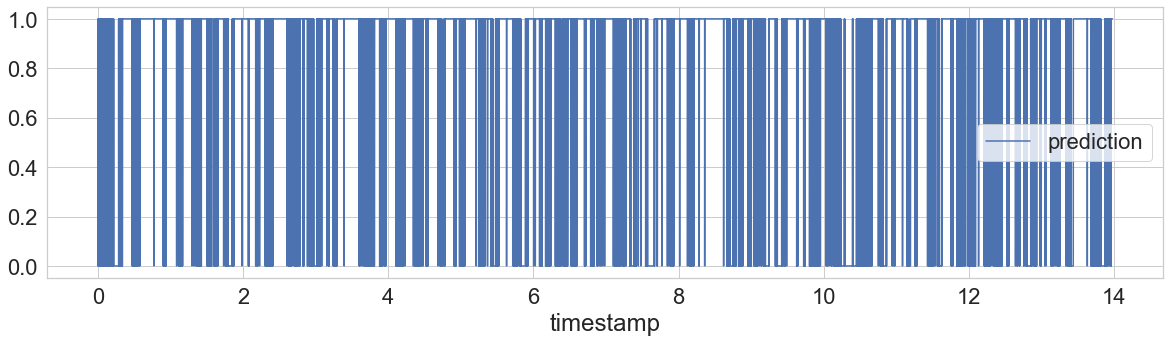

In [30]:
prediction = pd.read_json("data/07_model_output/prediction_min_speech.json")
prediction.plot.line(x="timestamp", y="prediction", figsize=(20,5));

In [31]:
metrics = pd.read_json("data/07_model_output/metrics_min_speech.json")
metrics.T

0
accuracy              0.795272
precision             0.911992
recall                0.849165
f1                    0.879458
false_rejection_rate  0.150835

##### Method 2: constraining the loss function with my custom loss

I modified the model to predict a sequence of labels. I implemented a Gru layer that outputs a (.., T timesteps, ..) fed to replaced a classification layer. I replaced the Dense classification layer used for the former model by a TimeDistributed Dense layer with a softmax activation function to predict a sequence of (T timesteps, 2 classes) label probabilities. I added a penalty to the loss function such that each occurrence of minimum speech time violation with the choosen a "timesteps" period increases the loss by +1.

I display my custom loss function below (see `src.vad.pipelines.train.nodes.MinSpeechLoss`).

```python
class MinSpeechLoss(tf.keras.losses.Loss):
    """Loss penalized to enforce a minimum speech time"""

    def __init__(self):
        """Instantiate loss constrained to enforce a minimum speech time"""
        super().__init__()

    def call(self, y_true, y_pred):
        # replicate y_pred over timestep axis and calculate loss
        cce = CategoricalCrossentropy()
        cce_loss = cce(y_true, y_pred)
        cce_loss = tf.convert_to_tensor(cce_loss)

        # penalize minimum speech violations
        minspeech_loss = get_penalty(y_pred)
        return cce_loss + minspeech_loss

    @classmethod
    def from_config(cls, config):
        return cls(**config)
```

#### Applying label smoothing

I used categorical cross entropy loss and applied label smoothing (0.5). Label values are smoothed, relaxing the confidence on their values. For example, i applied a `label_smoothing=0.5` which corresponds to 0.5 for the non-speech label and 1 for the speech label.
```python
model.compile(
    loss=CategoricalCrossentropy(label_smoothing=0.5), ...    
)
 ```
 

##### Before smoothing


Train the model and predict in the terminal (linux): 

```bash
kedro run --pipeline train --env train
kedro run --pipeline predict --env predict
```

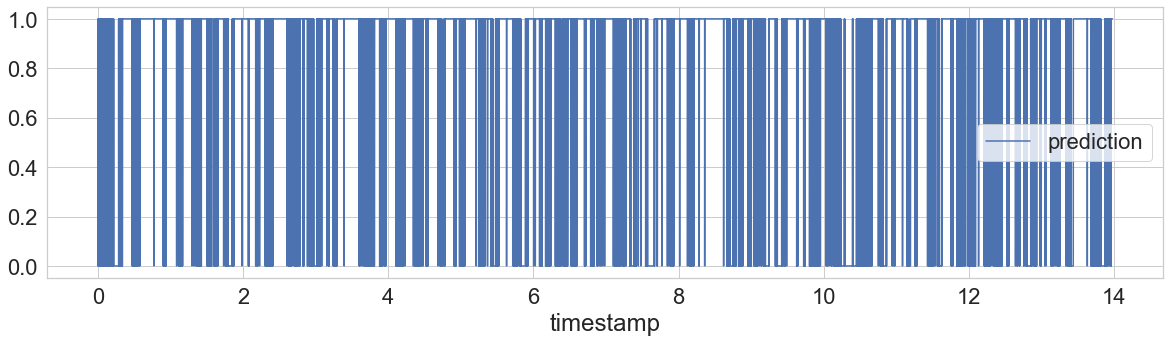

In [34]:
prediction = pd.read_json("data/07_model_output/prediction.json")
prediction.plot.line(x="timestamp", y="prediction", figsize=(20,5));

The performance metrics of the model on this example subject are:

In [35]:
metrics = pd.read_json("data/07_model_output/metrics.json")
metrics.T

0
accuracy              0.795272
precision             0.911992
recall                0.849165
f1                    0.879458
false_rejection_rate  0.150835

##### After smoothing ("label smoothing")

I train the model with label smoothing on 2.8 secs of my training subject's audio and calculated model predictions on test data from the example subject (another subject). To run inference run the commands below in the terminal: 

```bash
kedro run --pipeline train --env train_smooth  
kedro run --pipeline predict --env predict_smooth
```

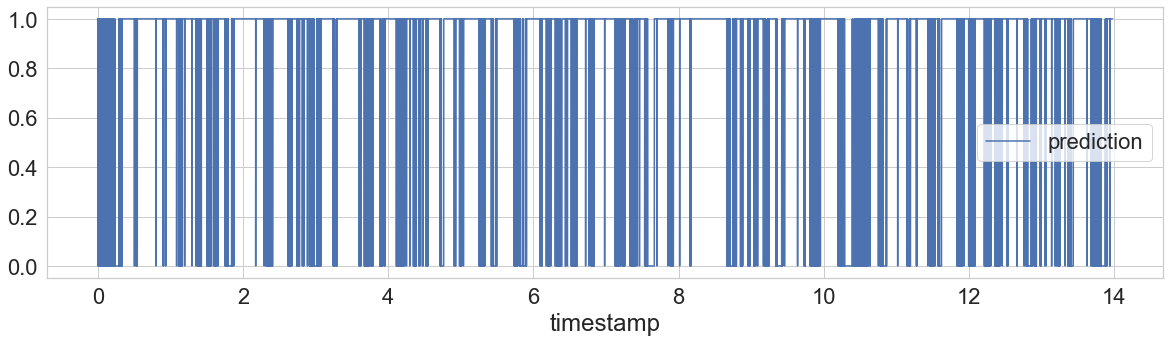

In [36]:
prediction = pd.read_json("data/07_model_output/prediction_smooth.json")
prediction.plot.line(x="timestamp", y="prediction", figsize=(20,5));

Smoothing the labels increased the performance on test data, producing lower FRR for this example.

In [37]:
metrics = pd.read_json("data/07_model_output/metrics_smooth.json")
metrics.T

0
accuracy              0.817639
precision             0.909771
recall                0.879921
f1                    0.894597
false_rejection_rate  0.120079

#### Enforcing a hangover of 100 ms

To add a hangover I modified the training labels before fitting the model. I chose a hangover of 100 ms (160 points at 16Khz) which was added before and after each speech event. I detected speech event intervals start and end timestamps and moved the start back in time by 160 points and the end forward by 160 points.

For example for speech interval 1: 

- before hangover (raw data): start_time: 160th point - end_time: 200th point
- after hangover: start_time: 0th point - end_time: 360th point

Increasing speech intervals with force model optimization to settle on weights that produce longer speech intervals.

To run the train and predict pipelines run the commands (in a linux/unix terminal):

```bash
kedro run --pipeline train --env train_hangover
kedro run --pipeline predict_and_eval --env predict_and_eval_hangover
```



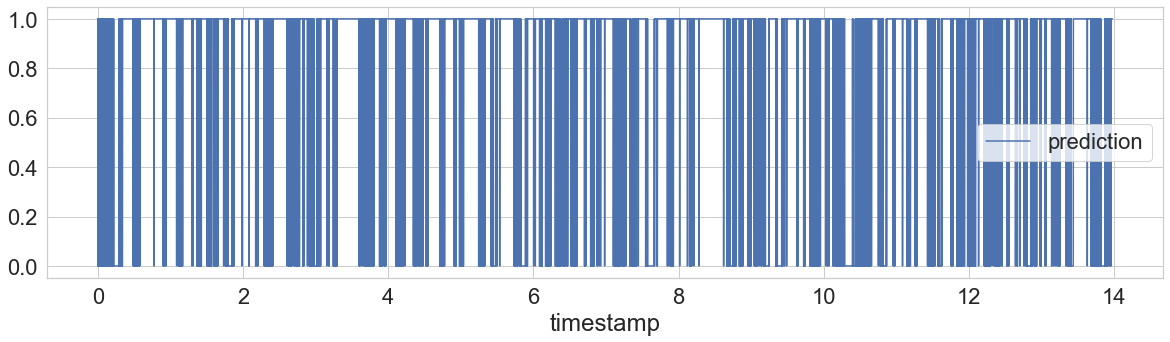

In [38]:
prediction = pd.read_json("data/07_model_output/prediction_hangover.json")
prediction.plot.line(x="timestamp", y="prediction", figsize=(20,5));

In [39]:
metrics = pd.read_json("data/07_model_output/metrics_hangover.json")
metrics.T

0
accuracy              0.801600
precision             0.911414
recall                0.857789
f1                    0.883789
false_rejection_rate  0.142211

## Conclusion & Discussions

I have developped a 1-layer GRU neural network that detects speech activity with an average of 9% of false rejection rat. It was trained on 2.8 secs audio from one speaker and tested on datasets from other speakers. The dataset contained audio with diverse types of voices which included male voices, female voices, synthetic voices, loud and low-volume voices, normal and faster paces. All development was realised on a resource-constrained device (a 2.3Gz RAM 4 cores MacOS laptop). 

I have implemented three voice activity detection modifications:
- **mimimum speech time**
    - by filtering out all speech events below a minimum speech time. I label them as not speech.
    - by creating a custom loss functions including a +1 penalty to cross categorical loss for each mimium speech time violation within windows of 10 ms (working, but not tuned and not optimal).
- **label smoothing** to reduce the too frequent and unrealistic alternance betwen speech events and no-speech intervals in predictions.
- **hangover** to enforce speech predictions with longer durations

I have used several tools and techniques:
- Tensorflow
    - tensorflow ops including control flow
    - tensorflow keras 
    - subclassing api for advanced model tuning
- Tensorflow board
- mlflow
- kedro
- see the list of dependencies in requirements.txt

## Perspectives


To improve the model, i could apply a few preprocessing steps:

- data minmax rescaling between 0 and 1
- z-scoring 

to speed up learning. 

The audio recording were very pure, recorded in no-background noise conditions which is not representative of more realistic noisy conditions. I could improve model robustness to realistic conditions by augmenting the dataset with noisier audio such as:

- `MUSAN`: music, speech, noise (11 GB)
- Ava-speech dataset (8,9)

To better disambiguate the effect of various types of noise on the performance, I could trained the model on speeches engineered with diverse background noises using: 

- `QUT-Noise`: noise backgrounds (13, 14)
- `TIMIT`: clean speech

To improve the model the next steps would be to try a more thorough hyperparameter search:

- different learning rates
- more model architectures

The model should also be tested for online speech detection with streaming audio data from a microphone:
- Add a streaming inference pipeline that makes online predictions

I should work on matching several requirements :  
  - response latency: 
  - improving sensitivity by further lowering FRR
  - reduce computational cost at training and inference
  - reduce model memory footprint to enable deployment a constrained resource device such as an iphone or BlackBerry Pi, for example:
      - model quantization
      - serializing the model to a lighter file format such as tensorflow lite

## References

(13) https://research.qut.edu.au/saivt/databases/qut-noise-databases-and-protocols/

(14) Dean, D., Sridharan, S., Vogt, R., & Mason, M. (2010). The QUT-NOISE-TIMIT corpus for evaluation of voice activity detection algorithms. In Proceedings of the 11th Annual Conference of the International Speech Communication Association (pp. 3110-3113). International Speech Communication Association.  

(8) https://research.google.com/ava/download.html

(9) Gu, C., Sun, C., Ross, D. A., Vondrick, C., Pantofaru, C., Li, Y., ... & Malik, J. (2018). Ava: A video dataset of spatio-temporally localized atomic visual actions. In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (pp. 6047-6056).

## Supplementary results

## Speakers' first audio

SPEAKER 103 - PANEL 0
  data/01_raw/vad_data/103-1240-0001.wav
  data/01_raw/vad_data/103-1240-0001.json


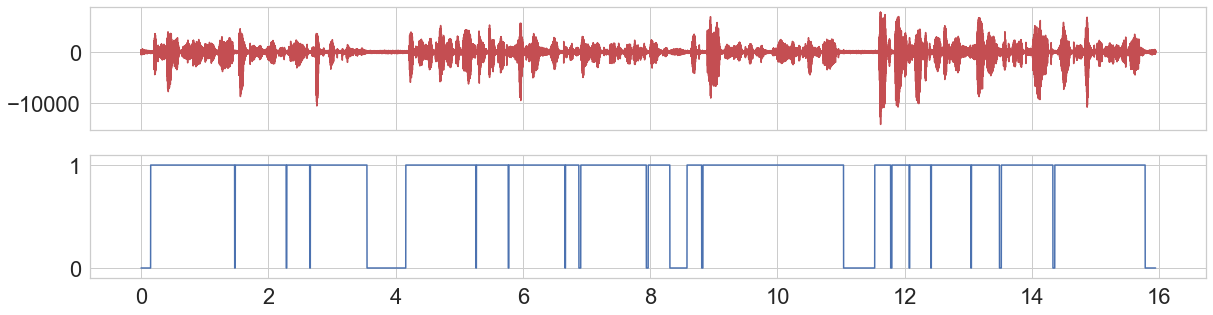

SPEAKER 1034 - PANEL 1
  data/01_raw/vad_data/1034-121119-0005.wav
  data/01_raw/vad_data/1034-121119-0005.json


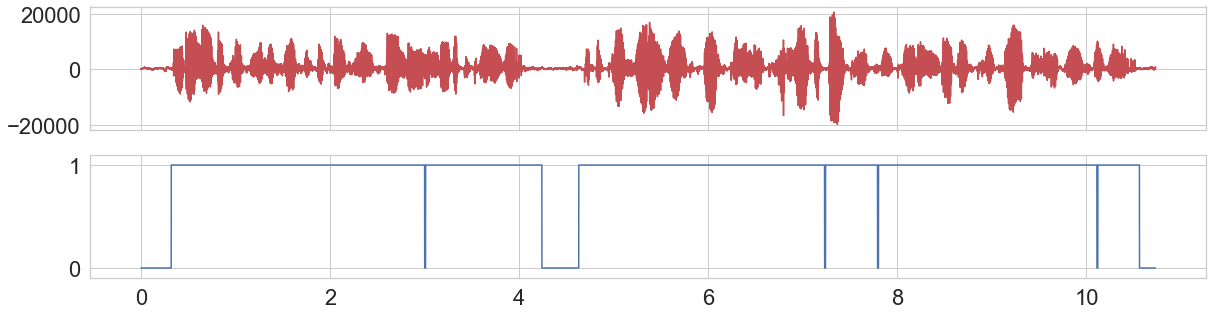

SPEAKER 1040 - PANEL 2
  data/01_raw/vad_data/1040-133433-0001.wav
  data/01_raw/vad_data/1040-133433-0001.json


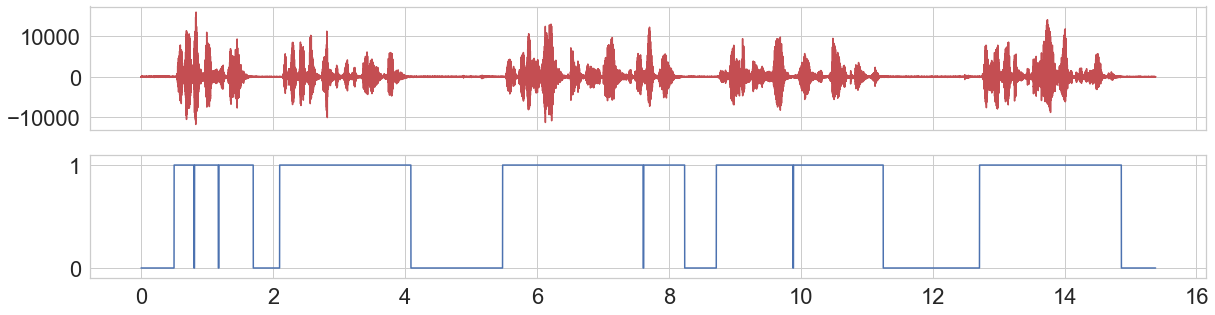

SPEAKER 1069 - PANEL 3
  data/01_raw/vad_data/1069-133699-0000.wav
  data/01_raw/vad_data/1069-133699-0000.json


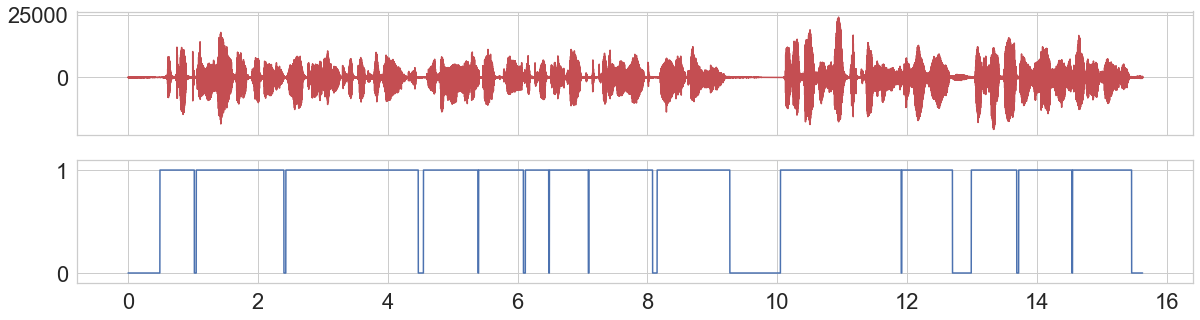

SPEAKER 1081 - PANEL 4
  data/01_raw/vad_data/1081-125237-0007.wav
  data/01_raw/vad_data/1081-125237-0007.json


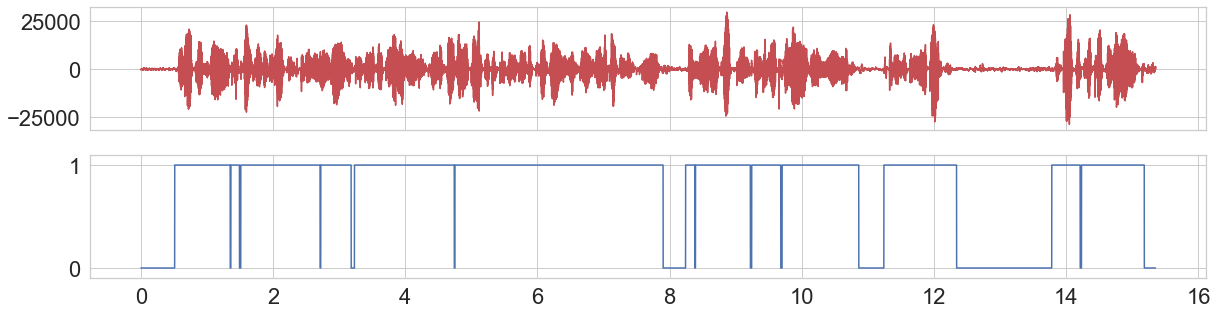

SPEAKER 1088 - PANEL 5
  data/01_raw/vad_data/1088-129236-0003.wav
  data/01_raw/vad_data/1088-129236-0003.json


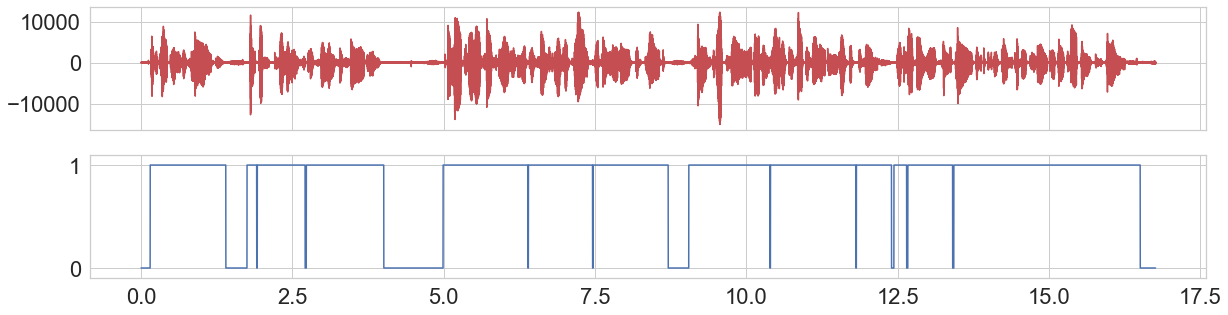

SPEAKER 1098 - PANEL 6
  data/01_raw/vad_data/1098-133695-0001.wav
  data/01_raw/vad_data/1098-133695-0001.json


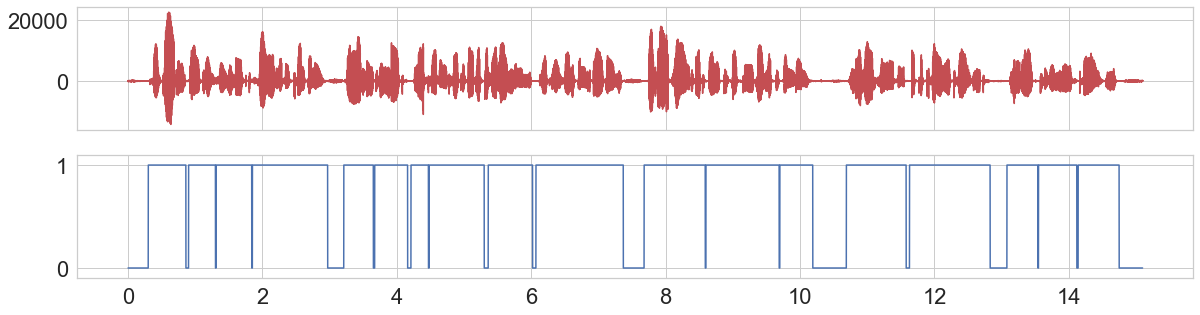

SPEAKER 1116 - PANEL 7
  data/01_raw/vad_data/1116-132847-0003.wav
  data/01_raw/vad_data/1116-132847-0003.json


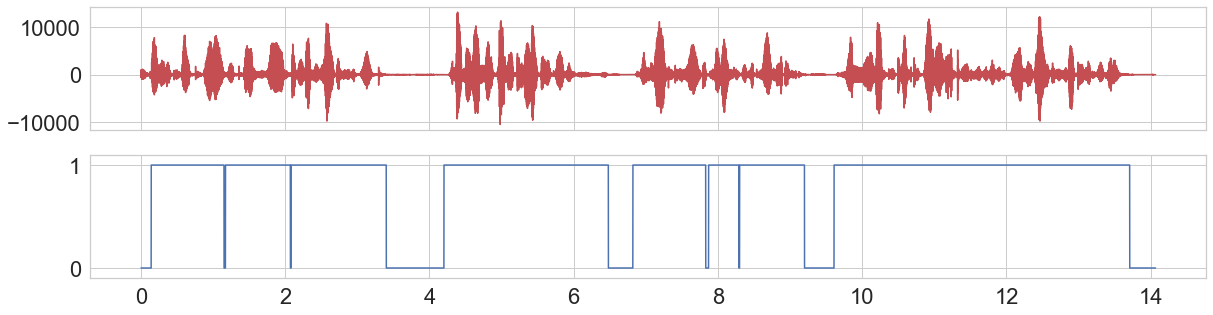

SPEAKER 118 - PANEL 8
  data/01_raw/vad_data/118-121721-0005.wav
  data/01_raw/vad_data/118-121721-0005.json


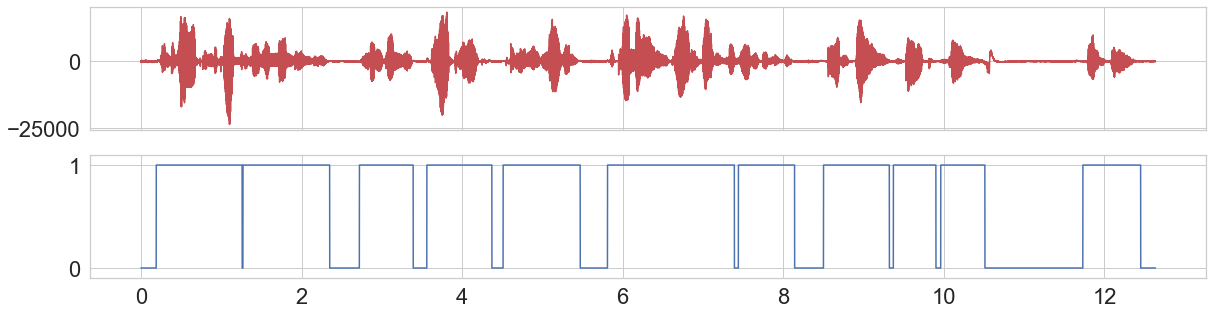

SPEAKER 1183 - PANEL 9
  data/01_raw/vad_data/1183-124566-0000.wav
  data/01_raw/vad_data/1183-124566-0000.json


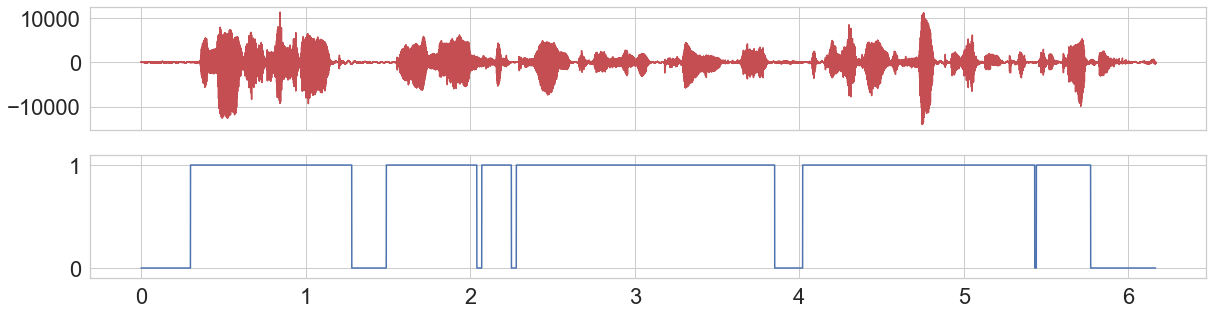

SPEAKER 1235 - PANEL 10
  data/01_raw/vad_data/1235-135883-0007.wav
  data/01_raw/vad_data/1235-135883-0007.json


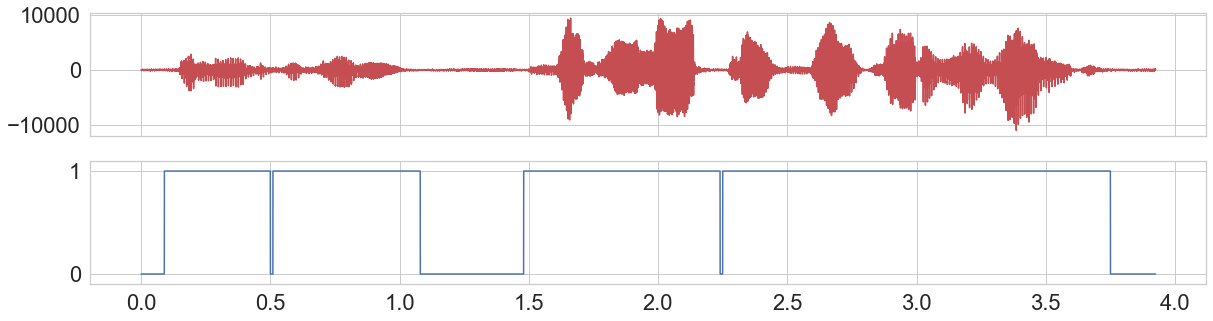

SPEAKER 1246 - PANEL 11
  data/01_raw/vad_data/1246-124548-0000.wav
  data/01_raw/vad_data/1246-124548-0000.json


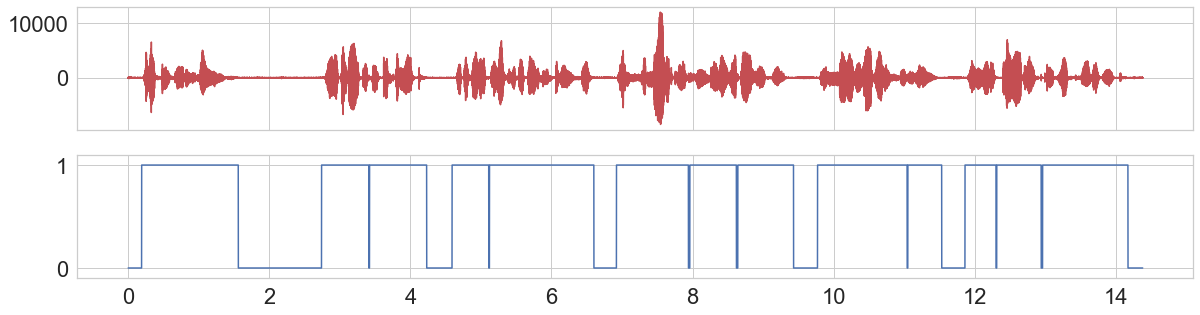

SPEAKER 125 - PANEL 12
  data/01_raw/vad_data/125-121124-0000.wav
  data/01_raw/vad_data/125-121124-0000.json


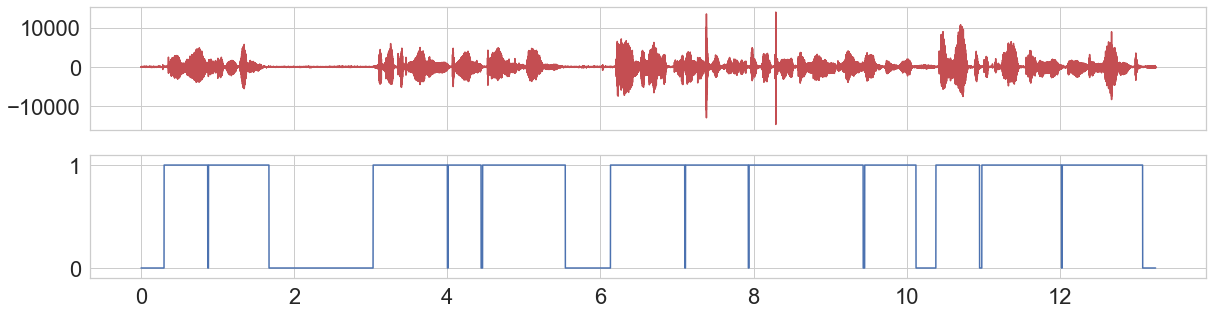

SPEAKER 1263 - PANEL 13
  data/01_raw/vad_data/1263-138246-0000.wav
  data/01_raw/vad_data/1263-138246-0000.json


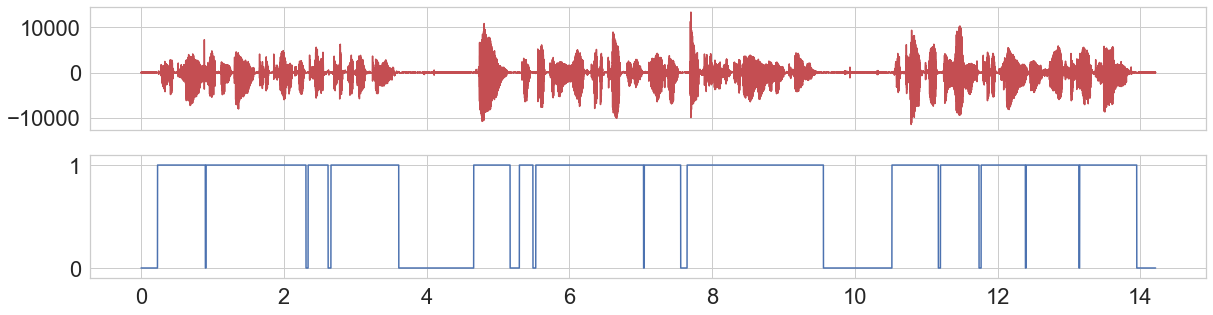

SPEAKER 1334 - PANEL 14
  data/01_raw/vad_data/1334-135589-0011.wav
  data/01_raw/vad_data/1334-135589-0011.json


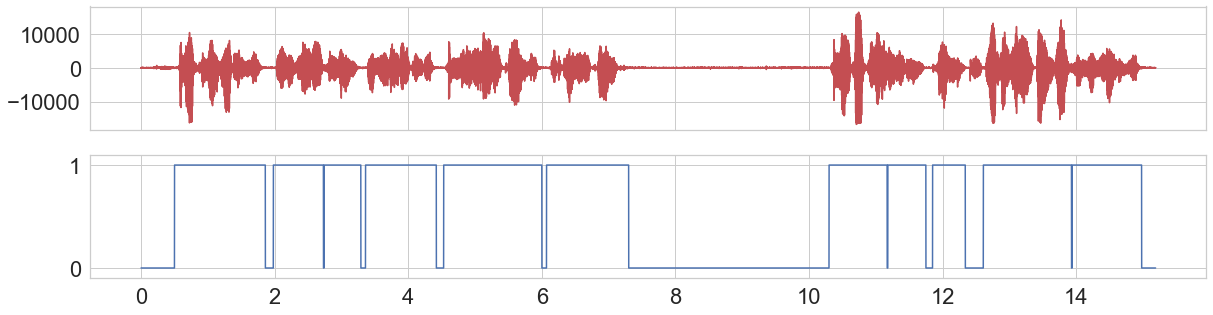

SPEAKER 1355 - PANEL 15
  data/01_raw/vad_data/1355-39947-0014.wav
  data/01_raw/vad_data/1355-39947-0014.json


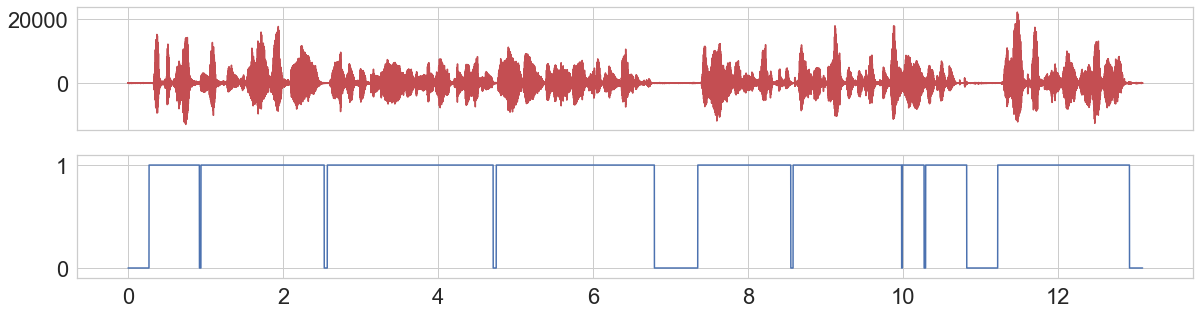

SPEAKER 1363 - PANEL 16
  data/01_raw/vad_data/1363-135842-0000.wav
  data/01_raw/vad_data/1363-135842-0000.json


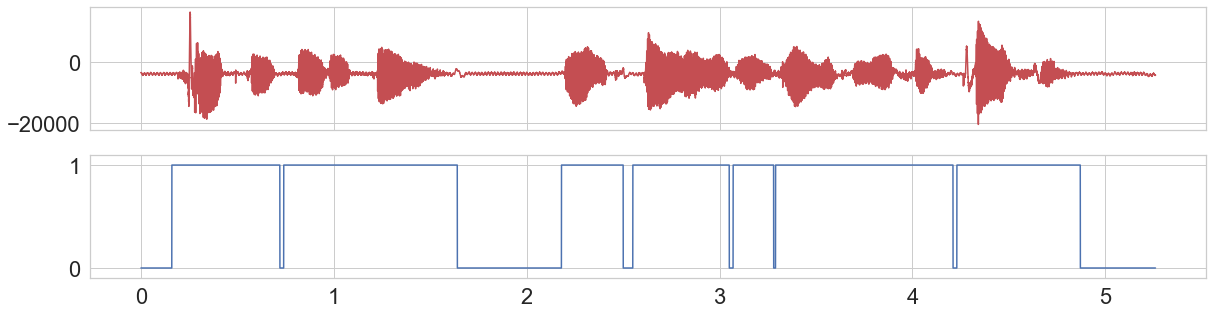

SPEAKER 1447 - PANEL 17
  data/01_raw/vad_data/1447-130550-0000.wav
  data/01_raw/vad_data/1447-130550-0000.json


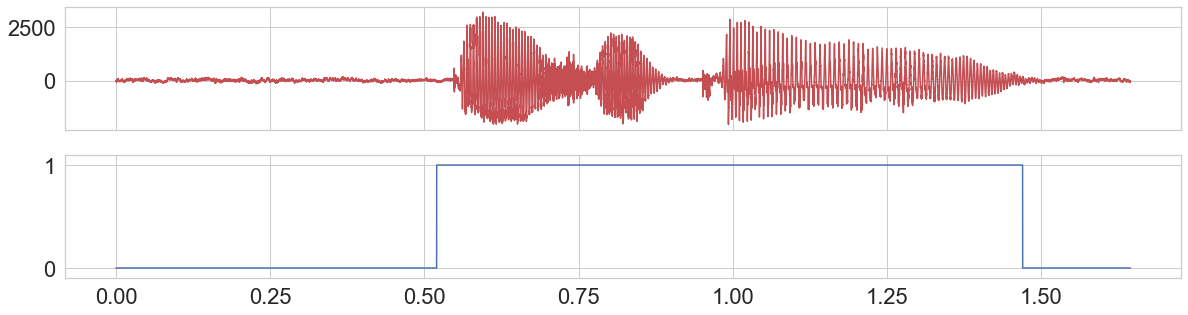

SPEAKER 1455 - PANEL 18
  data/01_raw/vad_data/1455-134435-0007.wav
  data/01_raw/vad_data/1455-134435-0007.json


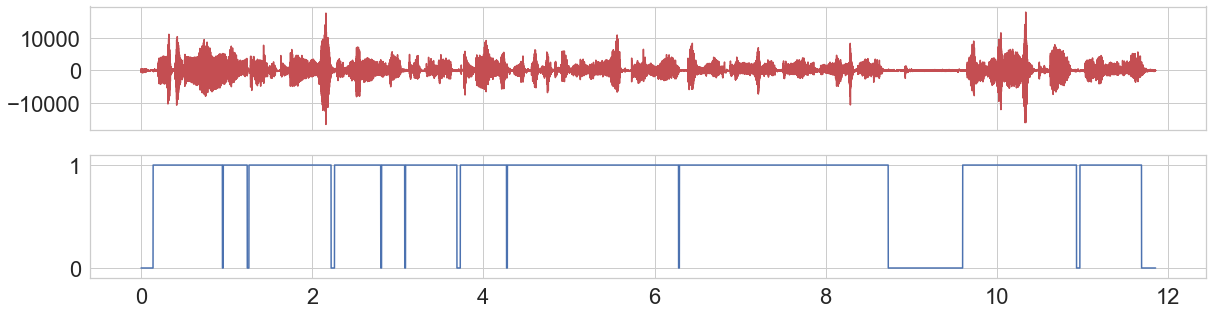

SPEAKER 150 - PANEL 19
  data/01_raw/vad_data/150-126107-0001.wav
  data/01_raw/vad_data/150-126107-0001.json


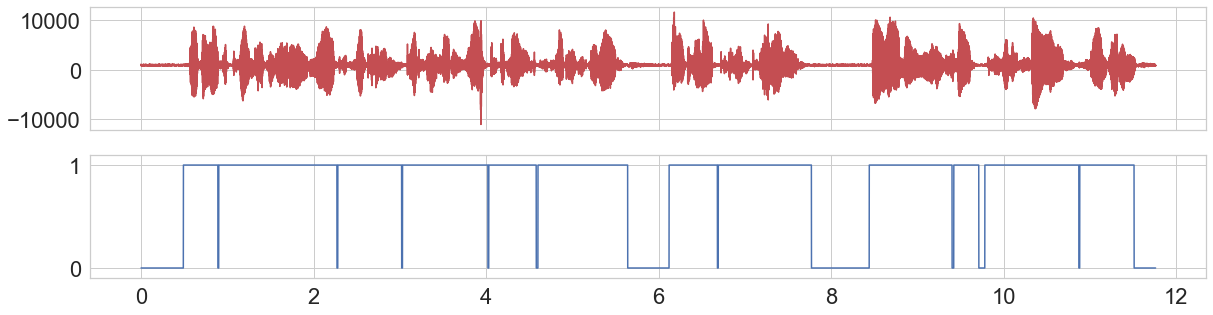

SPEAKER 1502 - PANEL 20
  data/01_raw/vad_data/1502-122615-0007.wav
  data/01_raw/vad_data/1502-122615-0007.json


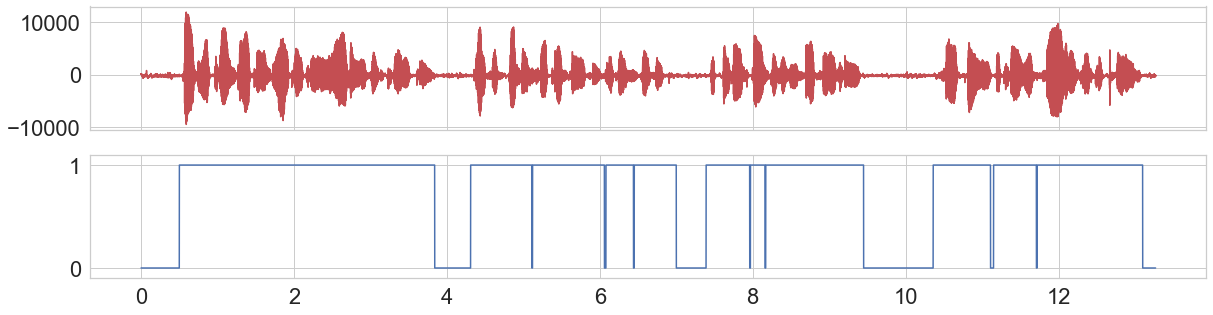

SPEAKER 1553 - PANEL 21
  data/01_raw/vad_data/1553-140047-0002.wav
  data/01_raw/vad_data/1553-140047-0002.json


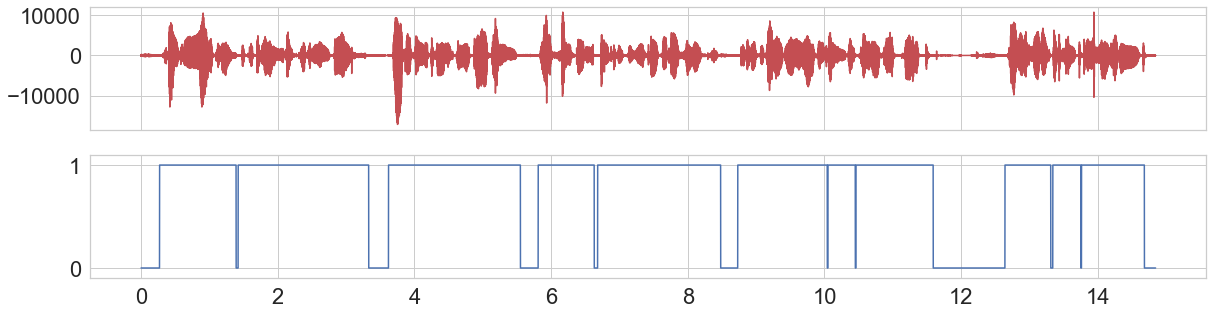

SPEAKER 1578 - PANEL 22
  data/01_raw/vad_data/1578-140045-0000.wav
  data/01_raw/vad_data/1578-140045-0000.json


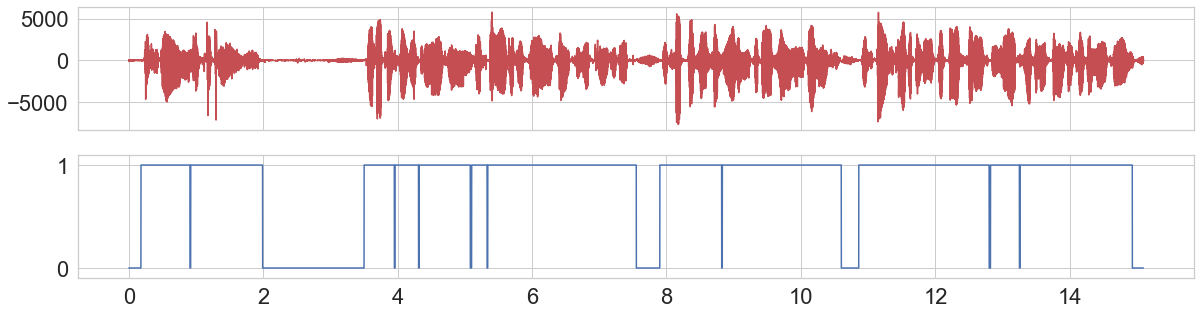

SPEAKER 1594 - PANEL 23
  data/01_raw/vad_data/1594-135914-0004.wav
  data/01_raw/vad_data/1594-135914-0004.json


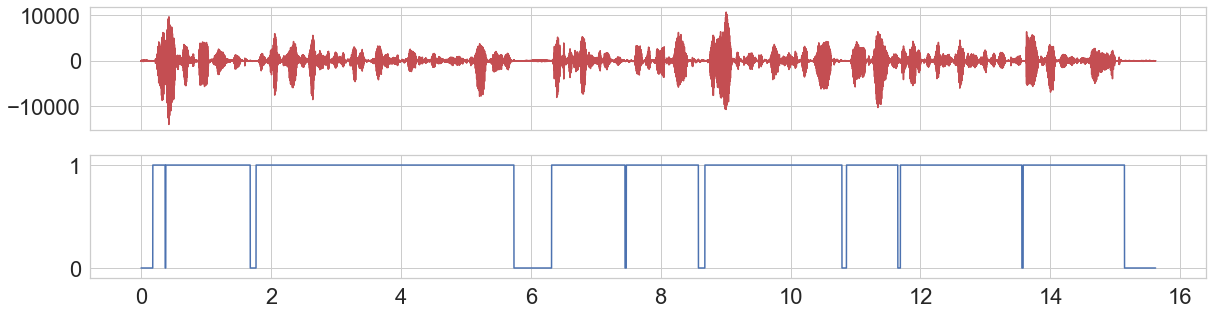

SPEAKER 1624 - PANEL 24
  data/01_raw/vad_data/1624-142933-0003.wav
  data/01_raw/vad_data/1624-142933-0003.json


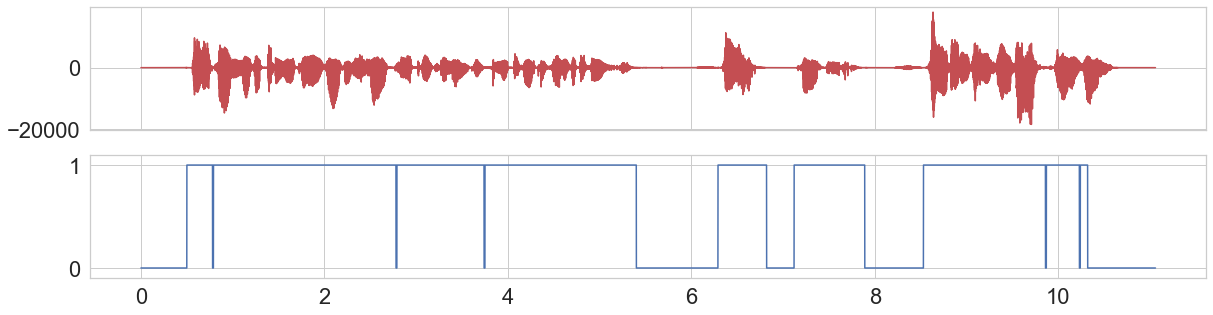

SPEAKER 163 - PANEL 25
  data/01_raw/vad_data/163-121908-0006.wav
  data/01_raw/vad_data/163-121908-0006.json


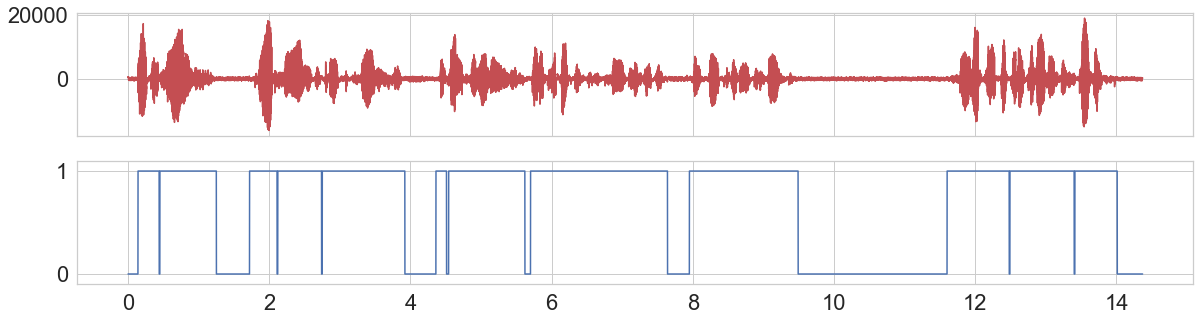

SPEAKER 1723 - PANEL 26
  data/01_raw/vad_data/1723-141149-0005.wav
  data/01_raw/vad_data/1723-141149-0005.json


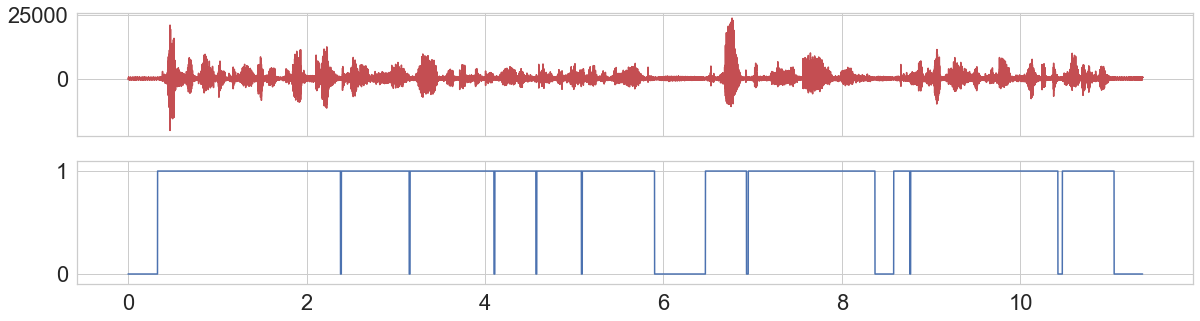

SPEAKER 1737 - PANEL 27
  data/01_raw/vad_data/1737-142396-0000.wav
  data/01_raw/vad_data/1737-142396-0000.json


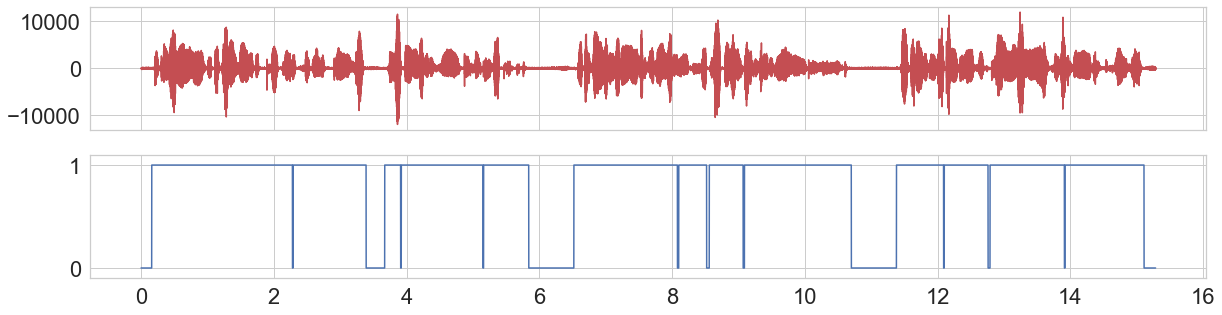

SPEAKER 1743 - PANEL 28
  data/01_raw/vad_data/1743-142912-0002.wav
  data/01_raw/vad_data/1743-142912-0002.json


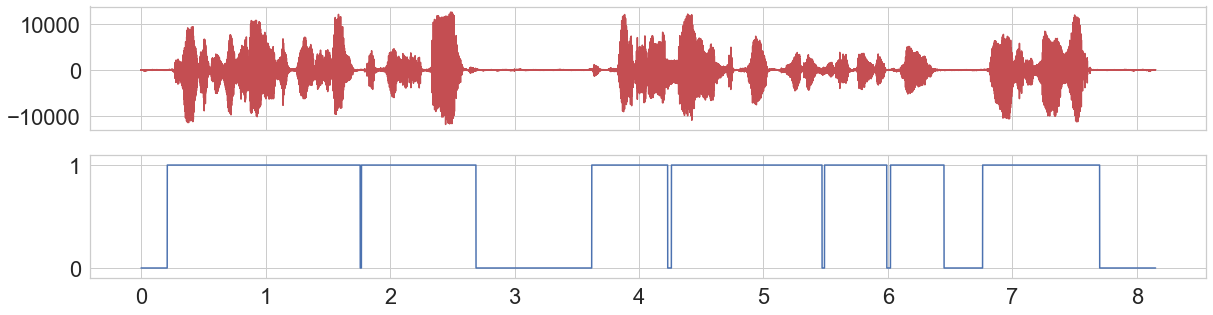

SPEAKER 1841 - PANEL 29
  data/01_raw/vad_data/1841-150351-0013.wav
  data/01_raw/vad_data/1841-150351-0013.json


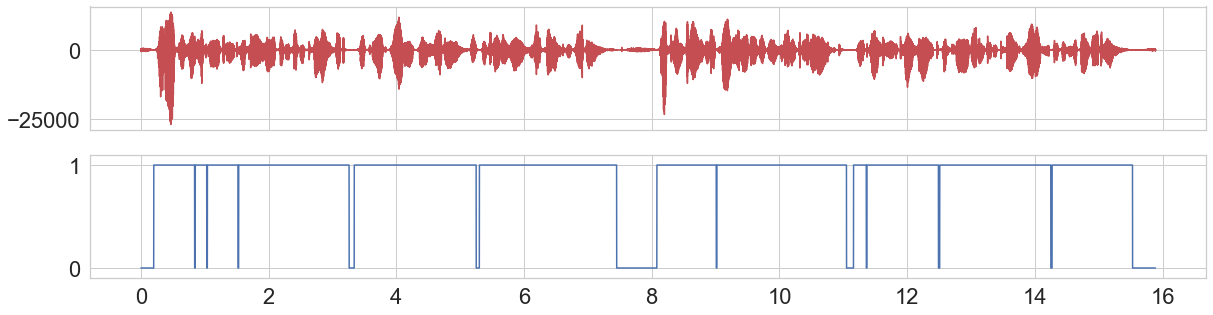

SPEAKER 1867 - PANEL 30
  data/01_raw/vad_data/1867-148436-0001.wav
  data/01_raw/vad_data/1867-148436-0001.json


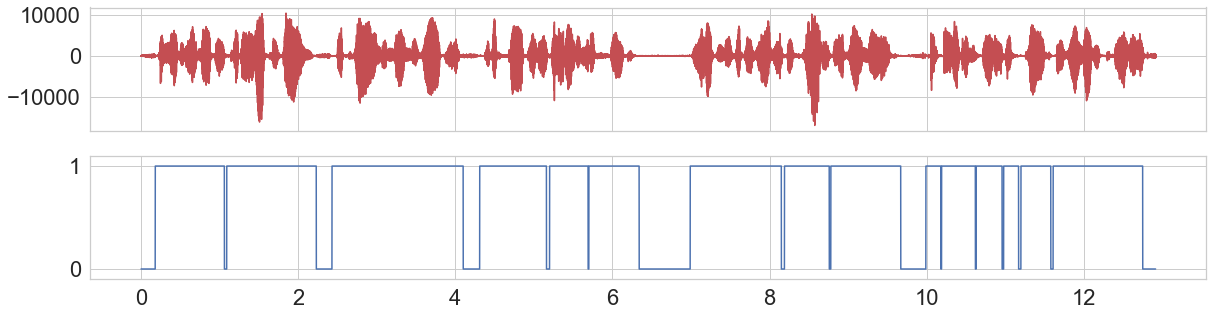

SPEAKER 1898 - PANEL 31
  data/01_raw/vad_data/1898-145702-0007.wav
  data/01_raw/vad_data/1898-145702-0007.json


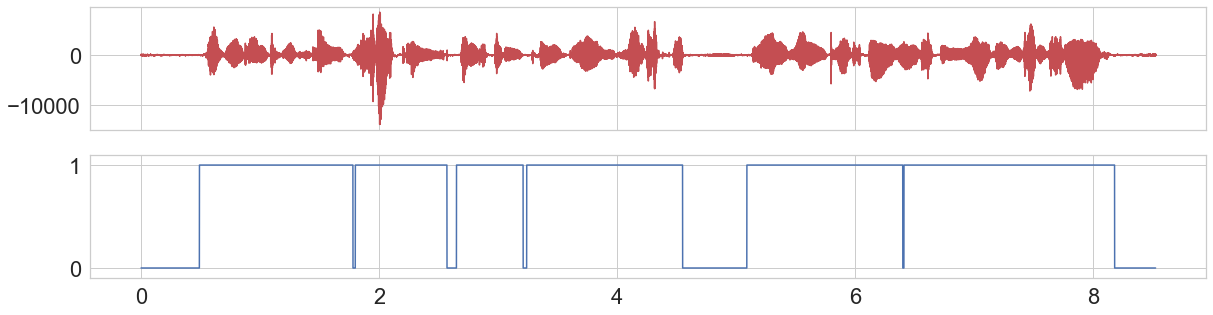

SPEAKER 19 - PANEL 32
  data/01_raw/vad_data/19-198-0003.wav
  data/01_raw/vad_data/19-198-0003.json


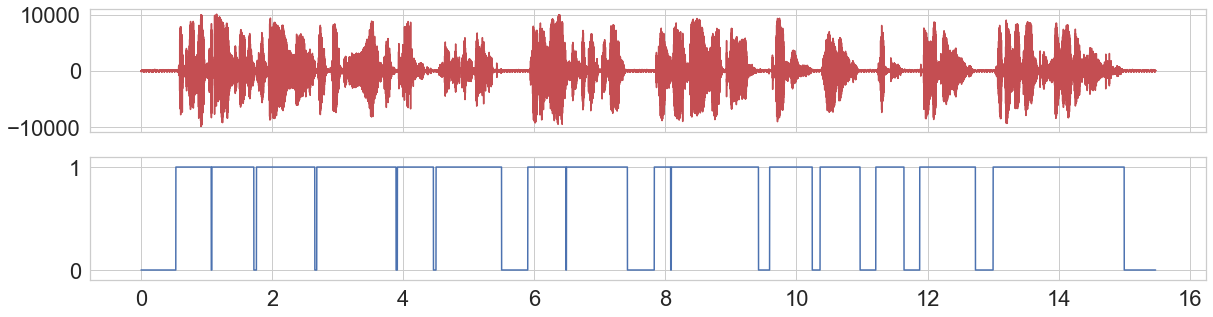

SPEAKER 1926 - PANEL 33
  data/01_raw/vad_data/1926-143879-0002.wav
  data/01_raw/vad_data/1926-143879-0002.json


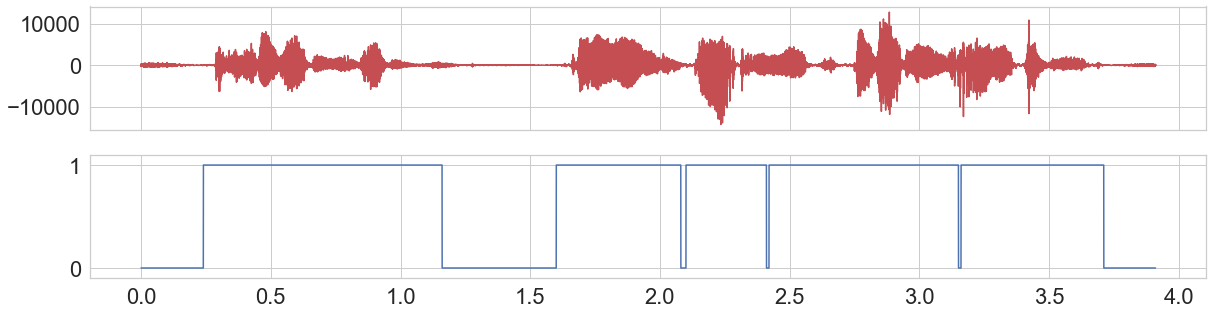

In [40]:
# show an example per speaker
_, exple_pos = np.unique(file_speaker, return_index=True, axis=0)
    
# sync audio and labels
tic = time.time()
for ix, exple in enumerate(exple_pos):
    print(f"SPEAKER {file_speaker[exple]} - PANEL {ix}")
    print(" " ,audio_files[exple])
    print(" " ,label_files[exple])    
    audio = read_X(audio_files[exple])
    label = load_Y(label_files[exple])
    synced = sync_audio_and_labels(audio, label)
    f, ax1, ax2 = plot_labelled_audio(
        audio["audio"]["metadata"]["timestamp"], 
        audio["audio"]["data"], 
        audio["label"], 
        n_sample=len(audio["label"]), 
    )

## Supplementary methods

### Experimental run tracking

Each run parameters was tracked with mlflow api.

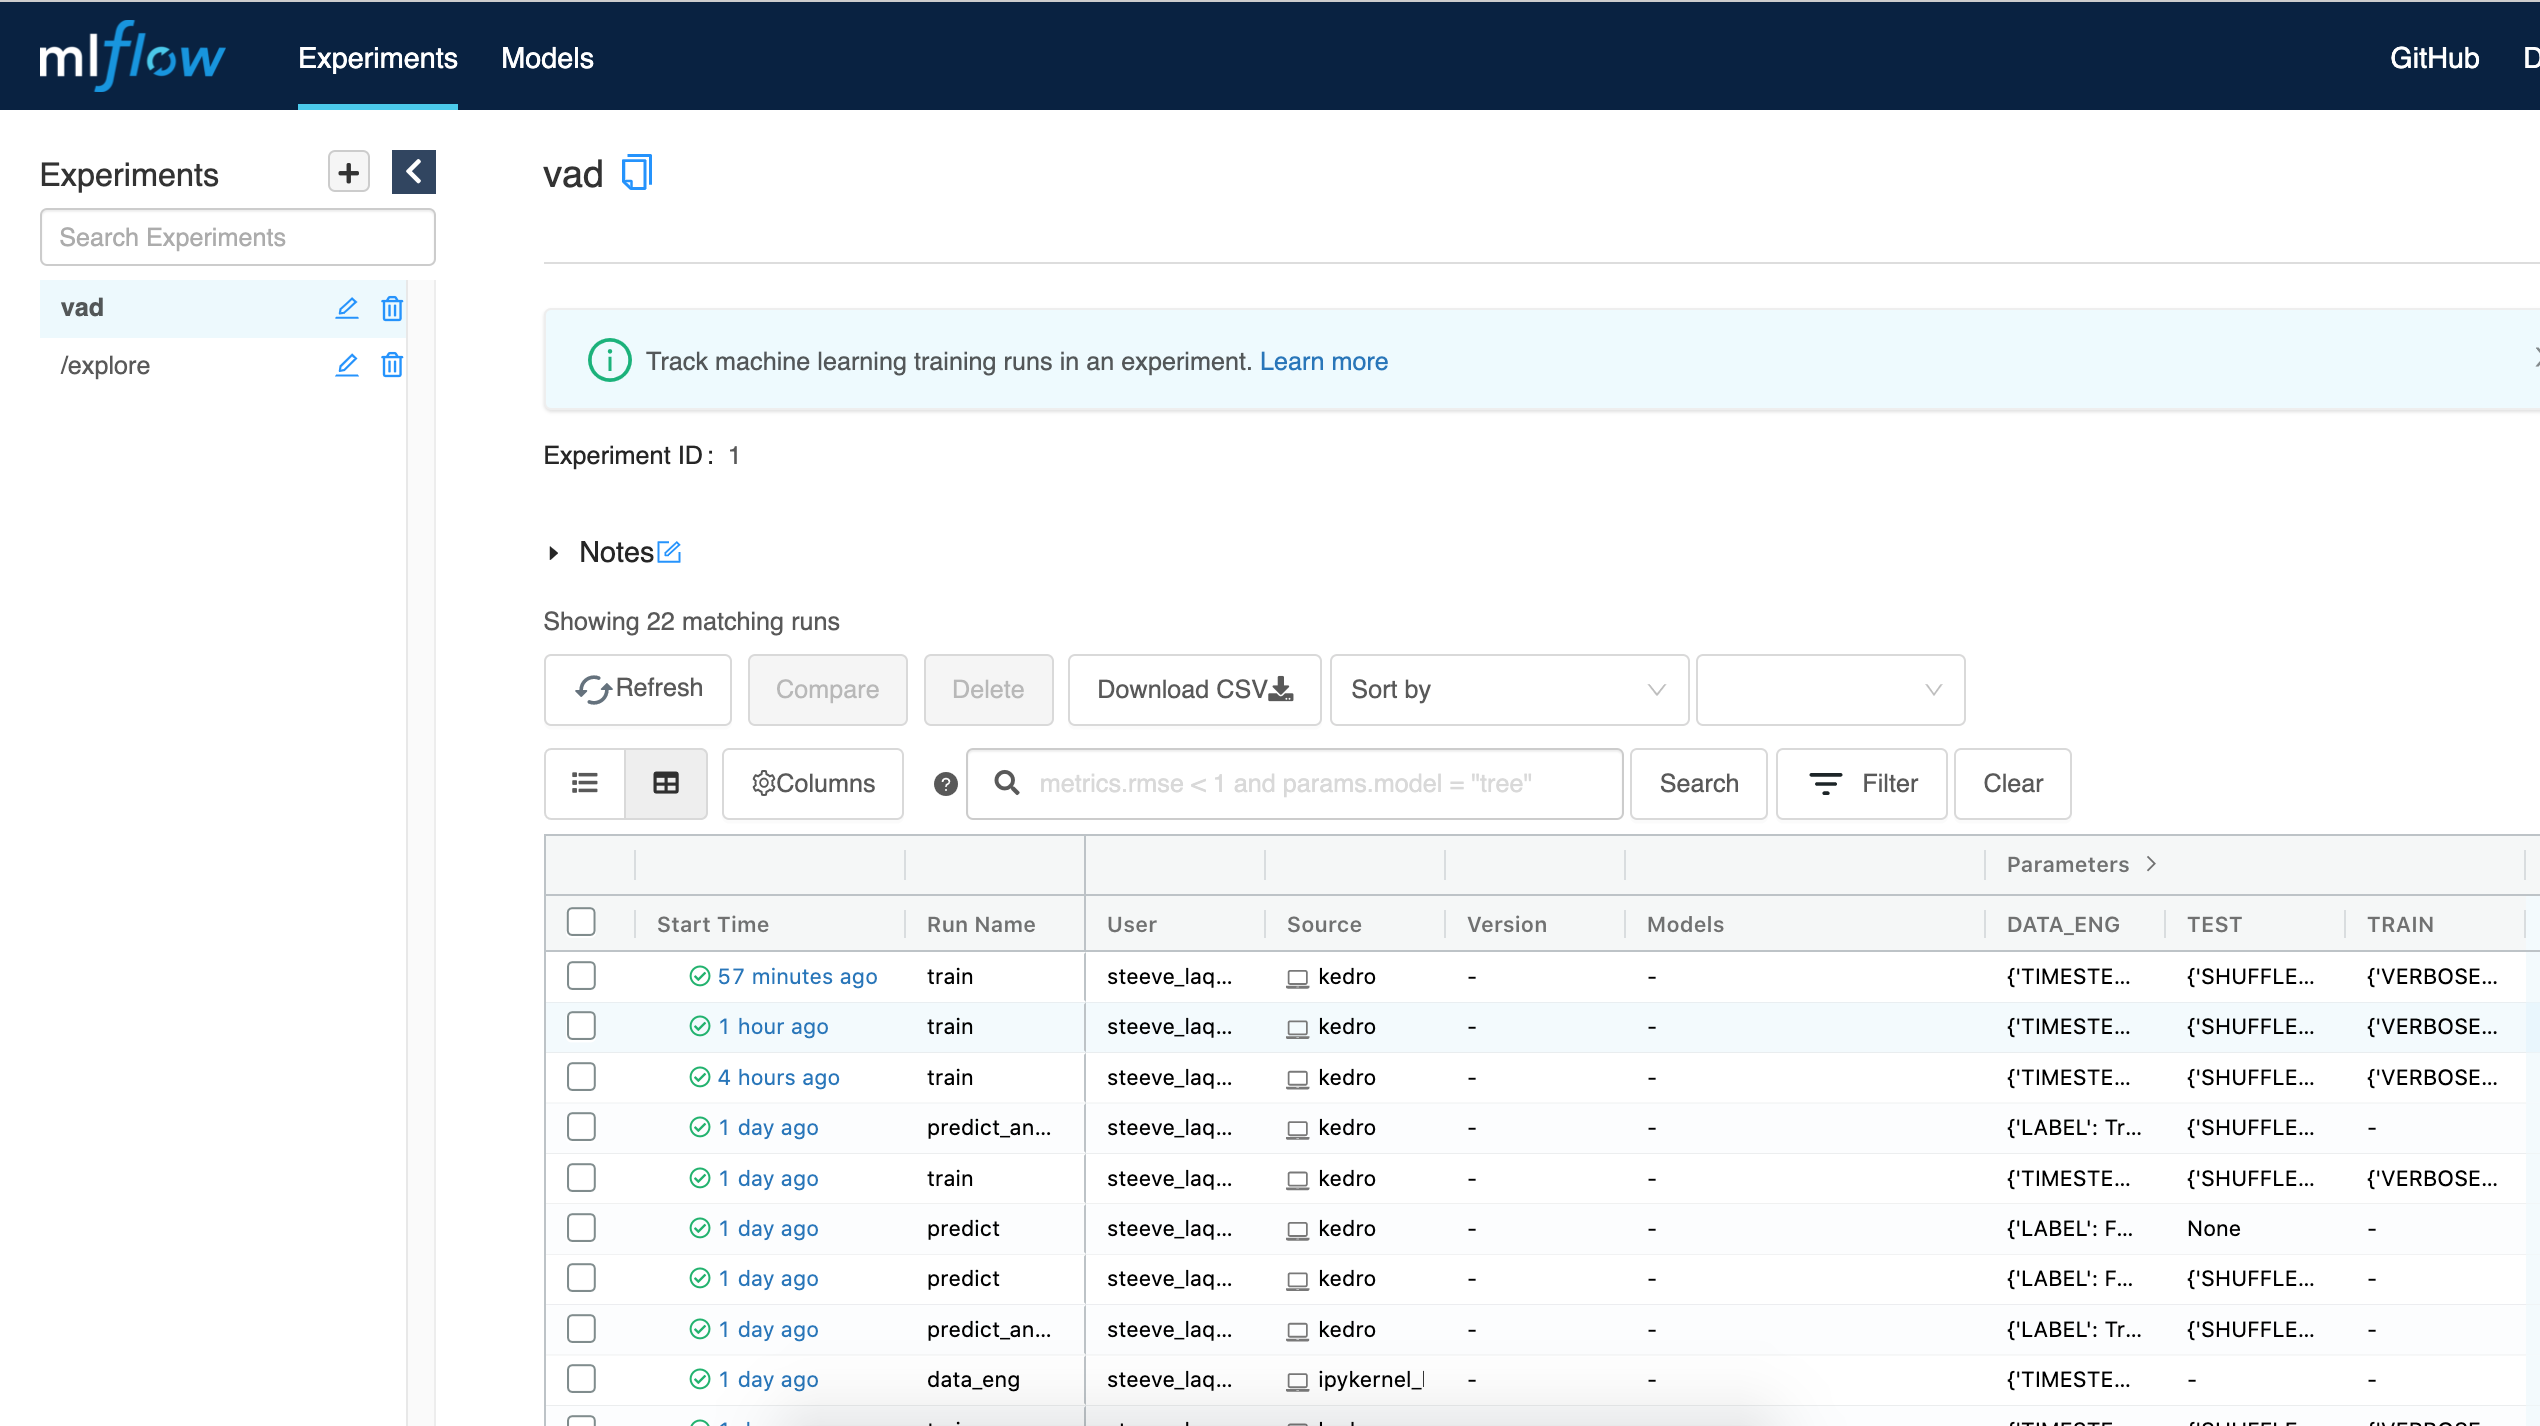

In [41]:
# load kedro inference pipeline
from IPython.display import Image
Image(filename='notebooks/assets/mlflow_tracking.png') 

### Training pipeline

we display below the directed acyclic graph of our training pipeline, plotted with the `kedro-viz` api.

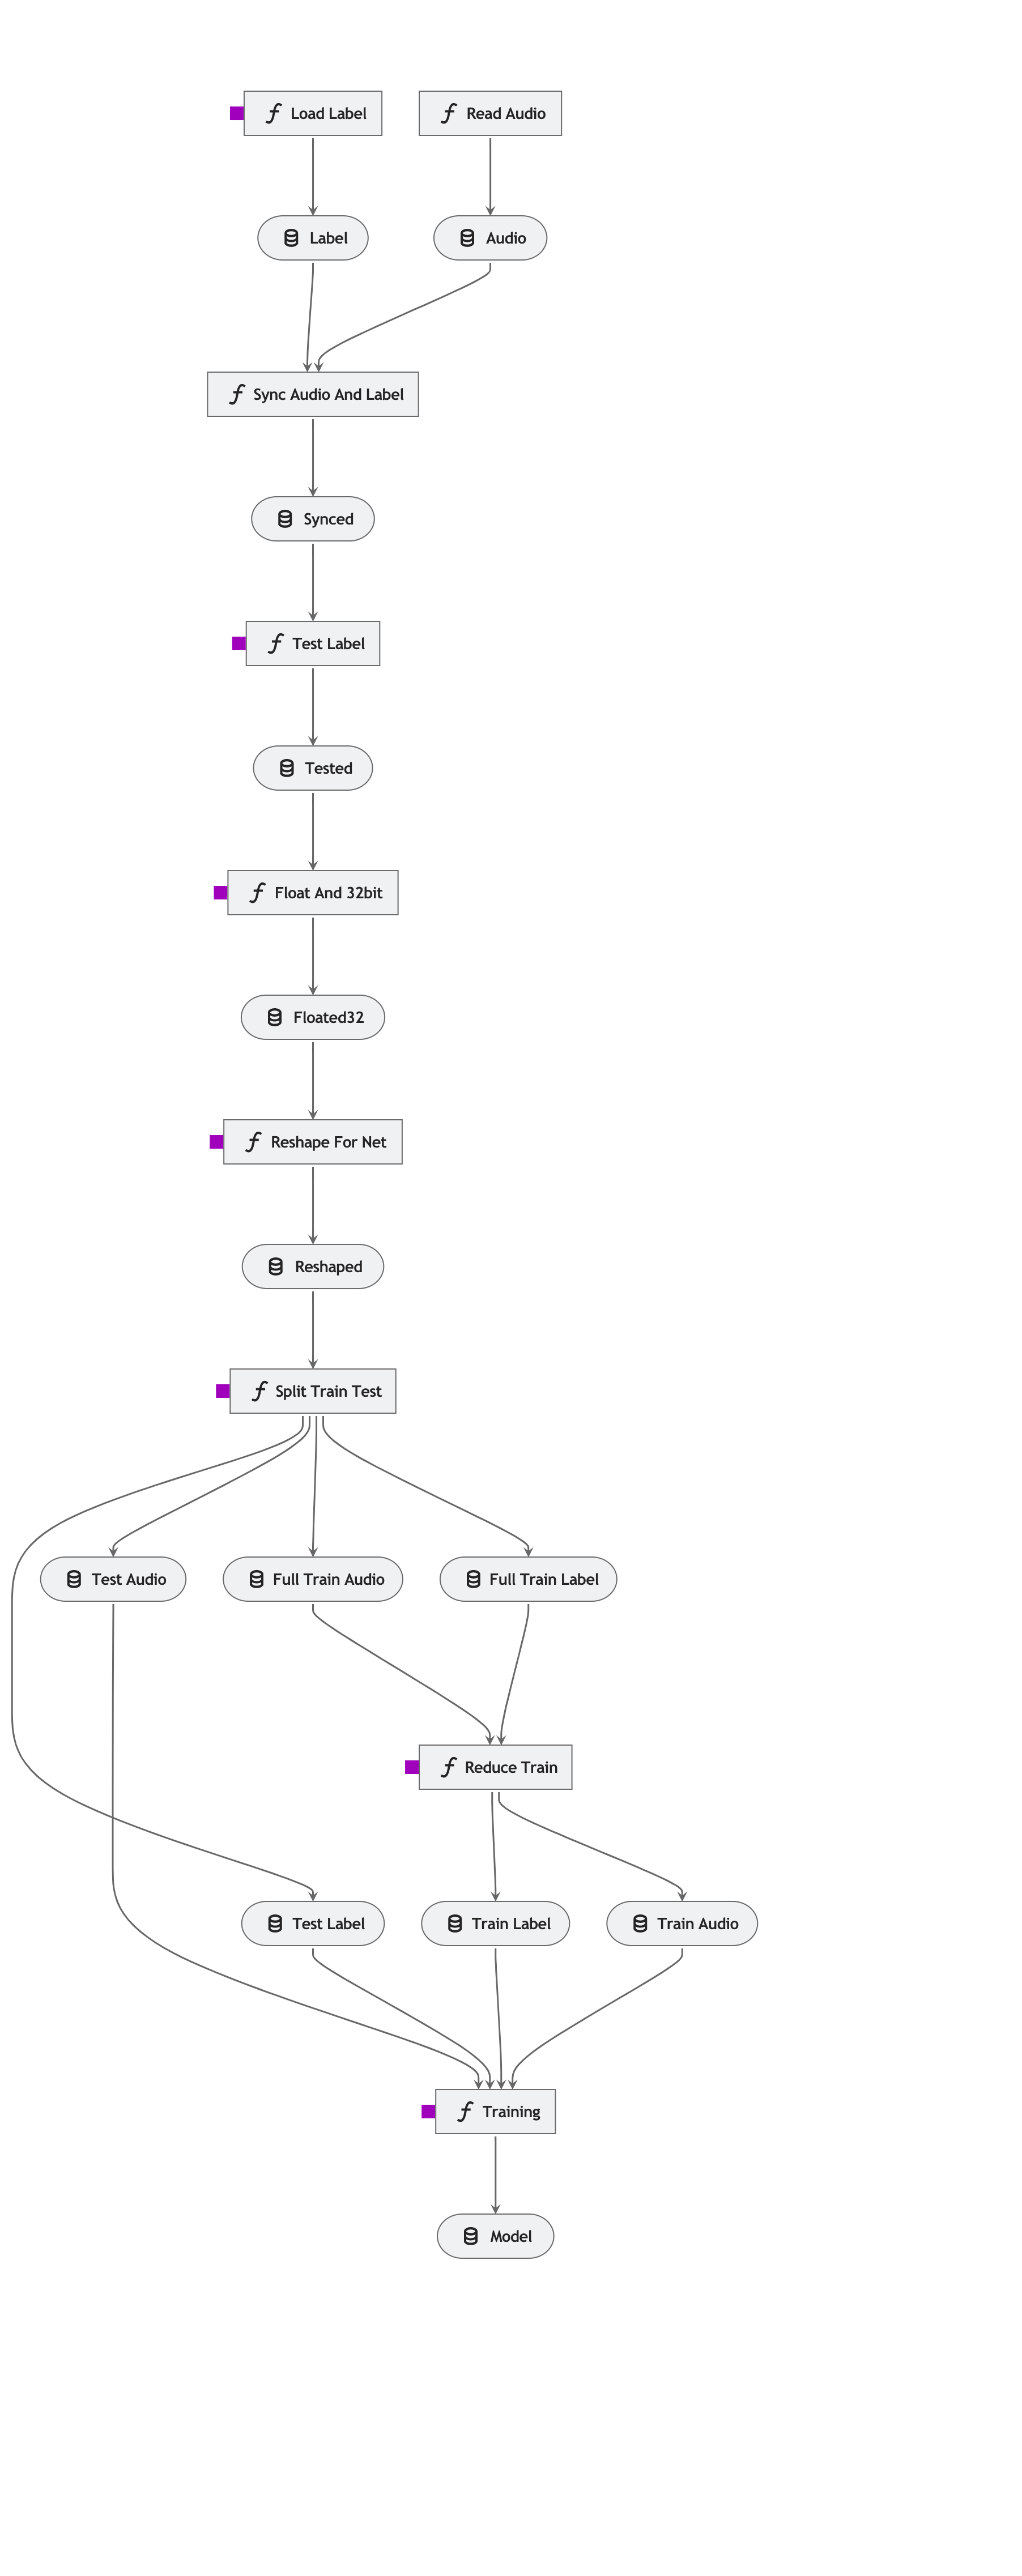

In [42]:
# load tensorboard conceptual graph
from IPython.display import Image
Image(filename='notebooks/assets/kedro_train_pipeline.png') 

### Inference pipeline

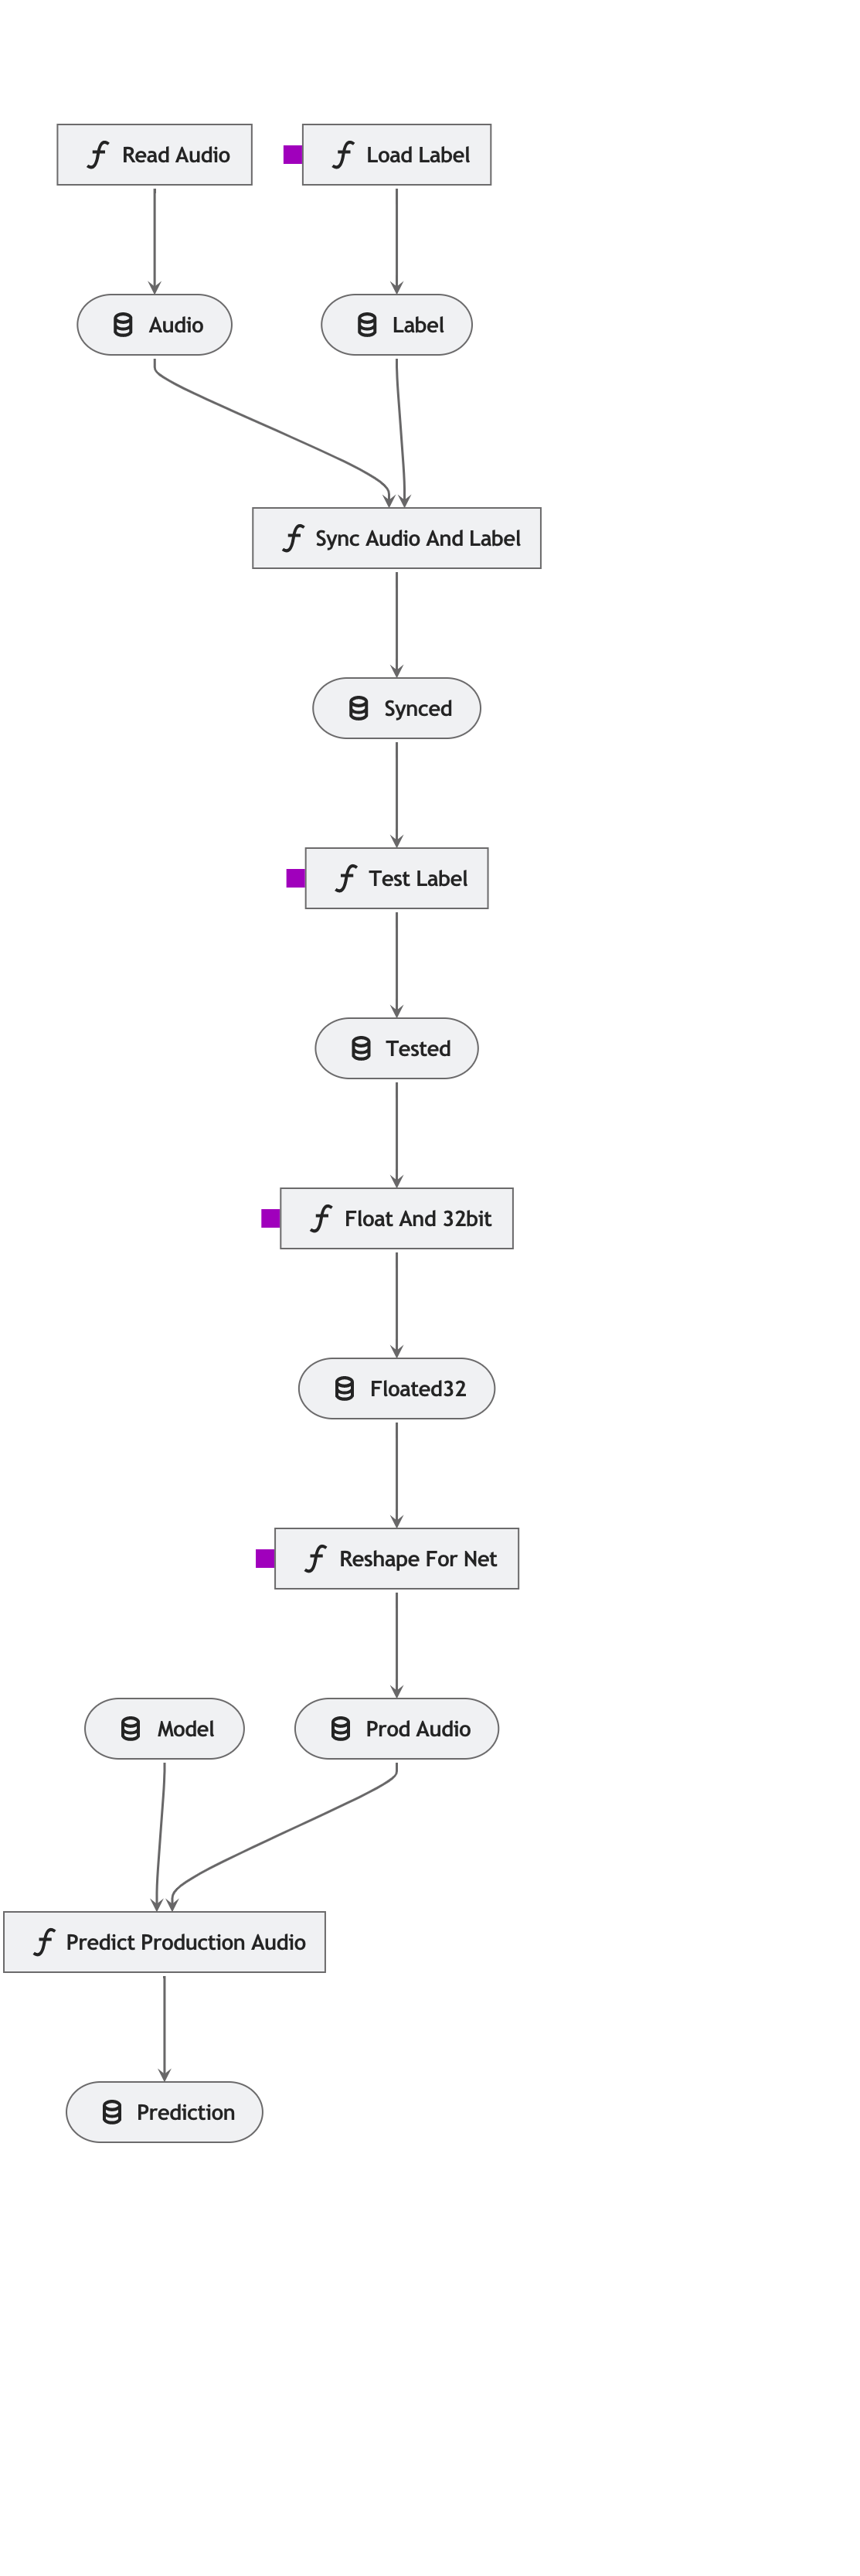

In [43]:
# load tensorboard conceptual graph
from IPython.display import Image
Image(filename='notebooks/assets/kedro_inference_pipeline.png') 

### Evaluation pipeline

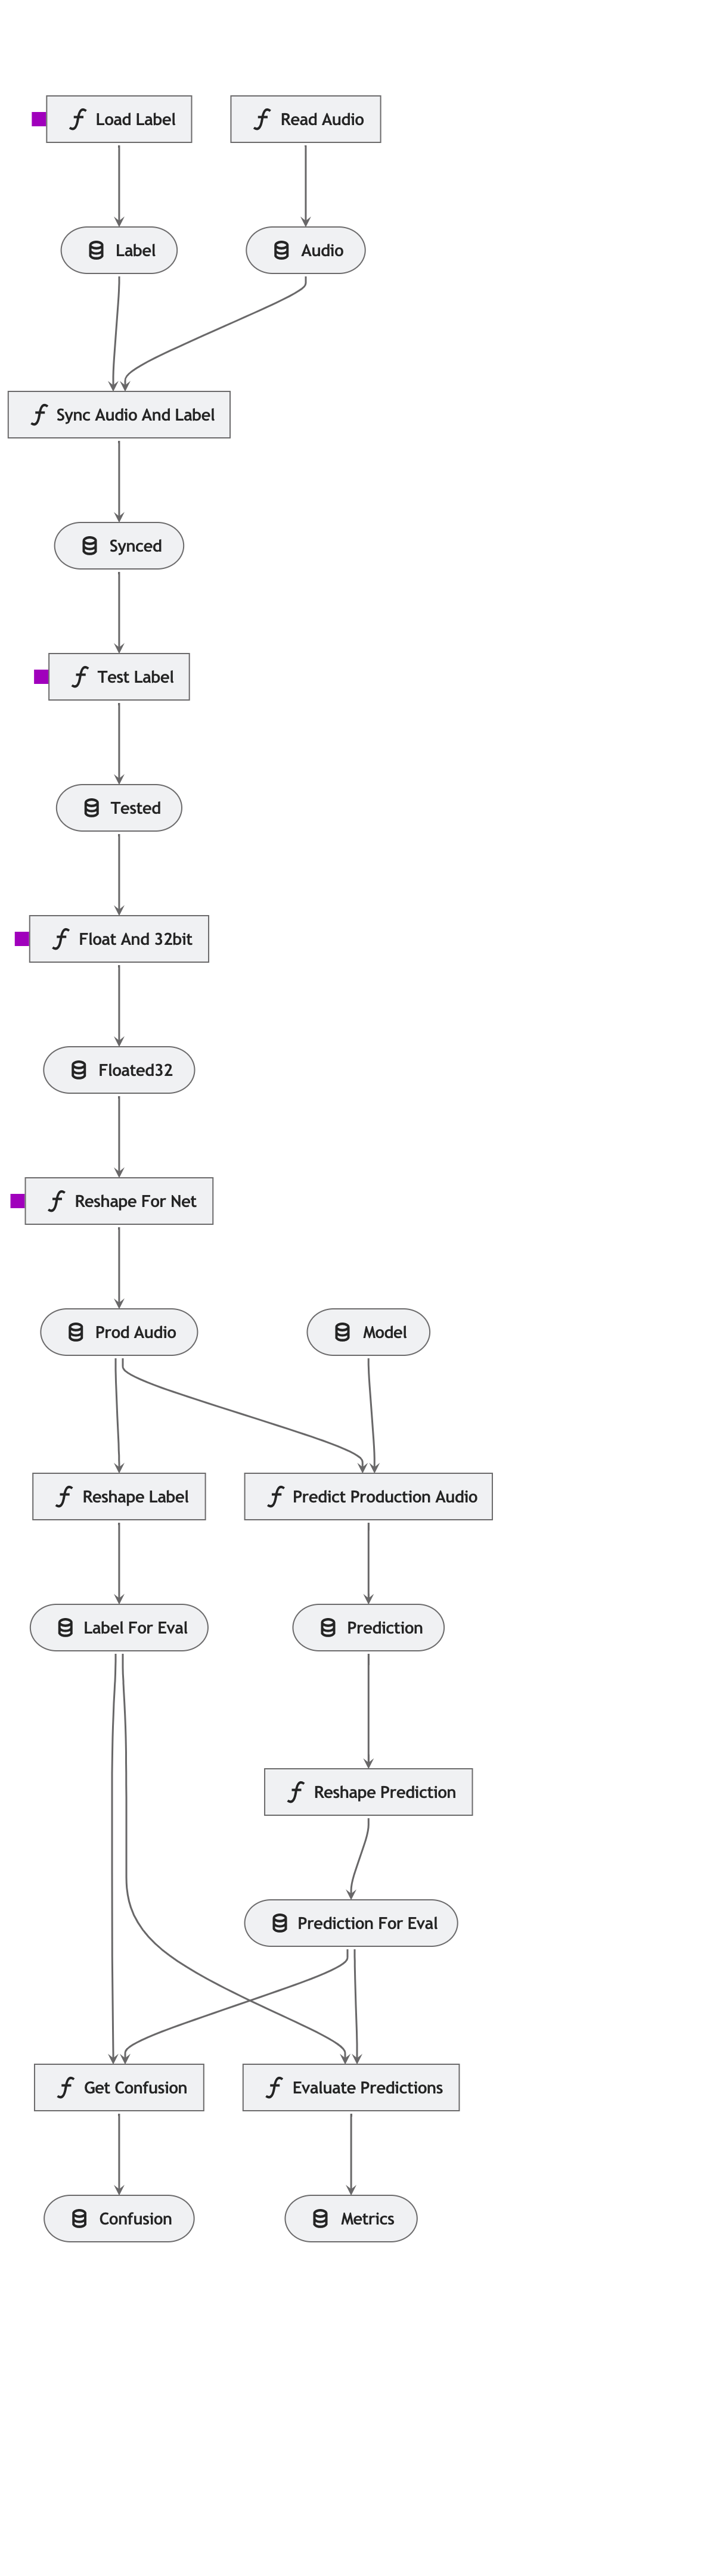

In [44]:
# load tensorboard conceptual graph
from IPython.display import Image
Image(filename='notebooks/assets/kedro_eval_pipeline.png') 